**&#169; CentraleSupélec. For any questions or comments, contact <frederic.pennerath@centralesupelec.fr>.**


# The problem: predicting popularity of tweets

Here we want to predict how popular will be a tweet just by observing the earlier retweets following it.
This study is meant to be instructive and to illustrate how to face a true data science problem properly.

## Code of conduct of data scientists

So if you don't want to end desesperate and start to pray the antique gods, practice some voodoo ceremony, and finally smash your computer with a baseball bat, you would better listen to the few preliminary advices:

* **Method** and **rigor**  are two required skills for a data scientist: do not think your computer is clever so that it will fix your mistakes for you. Always double check everything at every step before jumping to the next one.
* **Common sense** and **persistence** are also very important: don't be naive and overly optimistic.There is no magic in statistics and machine learning. Do not expect miracles when facing a problem that is complex in nature, impredictable or poorly instrumented (and here our problem is all three at once). So don't be disappointed if performances are low and never give up: continue working hard in order to provide a best effort solution.
* **Perspicacity** and **curiosity**: nothing worse for a being endowed with intelligence, than applying some black box model without understanding what's happening under the cover. Using your brain always pays off. Use your knowledge in statistics to get intuition about underlying issues. If you feel you miss something, try things, change experiment settings, etc, just to have a better sense of how this works.


## Vocabulary and reference

So before getting your hands dirty, let's just formalize the problem and introduce some common vocabulary.

Given an original tweet, its *cascade* is the collection of retweets it generates, where a retweet is abstracted as a *marked event*, i.e a couple (t,m) where:
* t is the timestamp of the event/retweet. Here we will asume time start at 0, that is, the original tweet of a cascade is posted at $t=0$.
* m is the mark of the event, also *called magnitude*, defined here as the number of followers the author of the retweet has.

The *popularity of a tweet* is measured as the *size of its cascade*, defined as the number of retweets the cascade contains (including the initial tweet).
Hereafter we consider the *problem of predicting the popularity of a tweet* after observing the earlier part of its cascade, during a given *observation window* of length $T_{obs}$ of typically 10 to 30 minutes starting from the initial tweet.
We base our work on marked Hawkes processes (introduced during the lectures) as described in the articles:

> [**SEISMIC: A Self-Exciting Point Process Model for Predicting Tweet Popularity**](http://snap.stanford.edu/seismic/seismic.pdf)  
> *Q. Zhao, M. Erdogdu, H. He, A. Rajaraman, J. Leskovec*  
> in **KDD'15:** *Proceedings of the ACM SIGKDD Conference on Knowledge Discovery and Data Mining (KDD), 2015*


> [**Feature Driven and Point Process Approaches for Popularity Prediction**](https://arxiv.org/abs/1608.04862)    
> *Swapnil Mishra, Marian-Andrei Rizoiu, Lexing Xie*  
> in **CIKM '16:** *Proceedings of the 25th ACM International on Conference on Information and Knowledge Management*

## Let's make it simple

The proposed models in the articles are however relatively complex to implement and to tune.
We here propose the simplest possible model based on Hawkes process so that you can implement and understand all the method by yourself (derivation of mathematical expressions, simulation, estimation of parameters by optimization, prediction, etc), at the sacrifice of the model performance.

**Therefore we expect from you to make the method operational, not to reach the same level of performance as the methods of the state of the art (obviously it won't).**





## Choice of model

Compared to the aferomentioned articles, we make a simpler choice for our model:
We assume the point process of retweets in a cascade is a Hawkes process with an exponential kernel, to keep derivations simple. During the lectures and class tutorial, we started to derive some useful expressions in this context. There are recalled hereafter.

Let represent a cascade by a point process $\{T_i \in \mathbb{R}^+ : i \in \mathbb{N}^*\}$ on the real half line. Assuming the initial tweet of the cascade is posted at $t = 0$, $T_1 = 0$ represents the initial tweet and $\{ T_i : i \geq 2\}$ are the subsequent retweet timestamps. 

Every time point $t_i$ is complemented by a useful piece of information, which is the number $m_i$ of followers of the author of retweet $t_i$. This number $m_i$ is hereafter referred as the *magnitude* of point $t_i$ (as a reference to earthquake replicas since earthquake modelling has been the initial application of Hawkes process). We formalize this by a so called *marked process* $\{(T_i, M_i) \in \mathbb{R}^ +\times \mathbb{R}^+ : i \in \mathbb{N}^*\}$, i.e where every point $t_i$ is *marked* by some magnitude $m_i$.

Given some time $t$, we denote $\mathcal{H}_{t}$ the history at time $t$, i.e the set $\mathcal{H}_t = \{(t_i,m_i) \}_{1 \leq i \leq n} : t_i \leq t\}$ of marked points observed up to time $t$.
Let denote $\{N_t : t \in \mathbb{R}^+ \}$ the equivalent counting process of $\{T_i\}$ equal to the number of (re)tweets at time $t$ for a given cascade. Its *conditional intensity* $\lambda^*(t)$ at time $t$ is defined as:
$$\lambda^*(t) = \sum_{i=1}^n \lambda_+(t_i, m_i) \, \phi(t-t_i)$$

where
* $\lambda_+(t,m)$ is the intensity increase due to occurrence of point $(t,m)$.
* The kernel $\phi(d)$ is the pdf of the delay $d$ before a follower retweets a message. References say that this delay typically follows a power-law density. However for sake of simplicity, we prefer an exponential kernel parameterized by responsiveness $\beta > 0$ whose density is
$$\phi(d) = \beta \, \exp(-\beta \, d) \, \mathbb{1}_{]0,+\infty[}(d)\quad.$$

**Note:** notation *$\mathbb{1}_A$ refers hereafter to the characteristic function of set $A$: $\mathbb{1}_A(x) = 1$ if $x \in A$, $0$ otherwise.*

We make the simplest choice for $\lambda_+(t,m)$:
$$\lambda_+(t,m) = p \, m \quad,$$
where $p$ is the average probability of a follower to retweet the message. Therefore $p$ quantifies the virality of the message content.

Specifying $\lambda^*(t)$ is sufficient to generate time points $t_i$.
However to generate marked points $(t_i,m_i)$, we also need to know how magnitudes are distributed.
Again to keep it simple, we just follow a very coarse assumption given in [Mishra et al. 16]. In this work, they observed that the numbers of followers of the whole population of Twitter users follow a negative **power-law distribution** whose density is characterized by two parameters, the negative power $\alpha > 2$ and the minimal magnitude $\mu \geq 1$:
$$
f_M(m) = \frac{\alpha-1}{\mu} \, \left(\frac{m}{\mu}\right)^{-\alpha}\, \mathbb{1}_{[\mu,+\infty[}(m) \quad .
$$
The authors then chosed $\mu = 1$ and found $\alpha = 2.016$ by fitting the theoretical distribution with a very large number of tweet samples.

> **Question:** Why is this very naive?

In summary, every cascade is thus only characterized by its two own parameters $(p,\beta)$ and one global constant parameter $\alpha$.

So let's start, by loading required modules and apply some default settings.

In [1]:
%matplotlib inline

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm import tqdm

In [2]:
np.set_printoptions(precision = 2, suppress=True) # Default precision when displaying numpy arrays 
mpl.rcParams['figure.figsize'] = [ 16, 8 ] # Default figure size

# Work first on simulated data

The purpose of this labwork is 
1. first to estimate the parameters of a cascade given its samples observed during an observation window 
2. then to use these estimated parameters to predict the final cascade size.

But... Getting an estimation algorithm working might sometimes be tricky.
A good practice to test and debug such an algorithm is to work first on simulated data before applying it to real data.
The first debugging stage consists in generating data from some known instance of the model (for some arbitrarily chosen parameter values) and then checking that the estimation algorithm is able to recover the right parameter values from these samples (for a sufficiently large number of them).
This allows to fix implementation problems intrinsic to the method (bugs, high variance, choice for hyper parameters, etc).
Only once the algorithm works well on simulated data, we can be confident in our algorithm and apply it to real data. We then know the error increase is mostly due to discrepancies between the model and the real data, not about the algorithm itself.

## Simulation algorithm

The first step is to implement an efficient algorithm for simulating a marked Hawkes process.
To simulate point processes from their conditional intensity function $t \mapsto \lambda^*(t)$, there are two general algorithms: one is based on *inverting the cumulative intensity* (see lecture), one based on rejection sampling (a notion that will be studied later in the course *algorithms for data science*) called the *thinning algorithm*.
In case of Hawkes processes, computing the intensity at time $t$ depends on the number $N_t$ of points observed before $t$. To generate one point, we thus need to loop at least $\Theta(N_t)$ times to evaluate its cumulative intensity.
Iterating on points, we get algorithms with at least a quadratic complexity.


### An efficient algorithm for exponential kernels

However choosing an exponential kernel allows to derive an efficient linear algorithm as shown below.
Assuming an exponential kernel 
$$\phi(d) = \beta \, \exp(-\beta \, d) \, \mathbb{1}_{> 0}(d)$$
and history $\mathcal{H}_{t_k}$ at some time point $t_k$ the conditional intensity $\lambda^*(t)$ for $t > t_k$ for the next point $T_{k+1}$ can be rewritten as
$$
\begin{align}
\lambda^*(t) & = \sum_{i=1}^{k} \lambda_+(t_i,m_i) \, \beta \, \exp(-\beta \, (t - t_i))\\
 & = \sum_{i=1}^{k} \lambda_+(t_i,m_i) \, \beta \, \exp(-\beta \, (t_k - t_i)) \, \exp(-\beta \, (t - t_k))\\
 & = \lambda^*(t_k) \, \exp(- \beta \, (t - t_k))
\end{align}
$$
where term $\lambda^*(t_k)$ can be updated in constant time, every time $k$ is increased (i.e a new time point is sampled) as detailed below:
$$
\begin{align}
\lambda^*(t_k) & = \sum_{i=1}^{k} \lambda_+(t_i,m_i) \, \beta \, \exp(-\beta \, (t_k - t_i))\\
& = \lambda^*(t_{k-1}) \, \exp(-\beta \, (t_k - t_{k-1})) + \lambda_+(t_k,m_k) \, \beta \quad .
\end{align}
$$

Now the remaining question is how to sample the next point $T_{k+1}$. This can be done by inverting the *cumulative intensity function* $t \mapsto \Lambda^*(t)$ (see lecture). 
Let $t$ be the value of the next point $T_{k+1}$. Then
$$
\begin{align}
\Lambda^*(t) & =  \int_{t_k}^{t} \lambda^*(\tau) \, d\tau  \\
& = \int_{t_k}^{t} \lambda^*(t_k) \, \exp(-\beta \, (\tau - t_k)) \, d\tau \\
& = \frac{\lambda^*(t_k)}{\beta} \, \left(1 - \exp(-\beta  \, (t - t_k)) \right)
\end{align}
$$

According to the theorem seen during the lectures, we know that:
$$\Lambda^*(T_{k+1}) \sim Exp(1)$$

Let $V \sim Exp(1)$, then
$$
\begin{align}
T_{k+1} & = {\Lambda^*}^{-1}(V)\\
& = t_k -\frac{1}{\beta} \, \log \left(1 - \frac{\beta}{\lambda^*(t_k)} \, V \right)
\end{align}
$$

Note that if $V \geq \frac{\lambda^*(t_k)}{\beta}$ however, there is no more time point and the process is over.

### Implementation and test
It is time to test this simulation algorithm. One provides the implementation for the case of a simple Hawkes process or equivalenty a marked Hawkes process such that $\lambda_+(t,m) = \kappa$ where kappa $\kappa$ is a parameter of the process.
For more flexibility in the simulation, we assume the intensity due to the initial tweet is different from $\kappa$, equal to some other constant $\lambda_0$.

Please read and understand function `simulate_exp_hawkes_process` with respect to the equations above.

In [3]:
def simulate_exp_hawkes_process(params, lambda0, max_size=2000):
    """
    Returns a 2D-array containing marked time points simulated from an exponential Hawkes process
    
    params   -- parameter tuple (kappa,beta) of the generating process
    lambda0  -- initial intensity at t = 0.
    max_size -- maximal authorized size of the cascade
    """
    
    kappa, beta = params    
    
    # The result is just a 1D array
    # However for further compatibility, we reserve a second colum for the magnitude of every point.
    # Every row thus describes a marked timepoint (ti, mi) with a magnitude set arbitrarily to one.

    # Create an unitialized array for optimization purpose (only memory allocation)
    T = np.empty((max_size,2))
    
    # Set magnitudes to 1.
    T[:,1] = 1.
    
    intensity = beta * lambda0
    t = 0.
    
    # Main loop
    for i in range(max_size):
        # Save the current point before generating the next one.
        T[i,0] = t
        
        # 
        u = np.random.uniform()
        v = -np.log(u)
        w = 1. - beta / intensity * v
        # Tests if process stops generating points.
        if w <= 0.:
            # Shrink T to remove unused rows
            T = T[:i,:]
            break
            
        # Otherwise computes the time jump dt and new time point t
        dt = - np.log(w) / beta
        t += dt
        
        # And update intensity accordingly
        intensity = intensity * np.exp(-beta * dt) + beta * kappa       
    return T

We also provide below a function `plot_cascade` for plotting the simulated cascade.

In [4]:
def plot_cascade(cascade, Tmax = None):
    plt.stem(cascade[:,0] / 60., cascade[:,1], use_line_collection=True)
    plt.yscale('log')
    if Tmax is not None:
        plt.xlim(None, Tmax/60)
    plt.xlabel('time (min)')
    plt.ylabel('magnitude (log)')

> ** Question **  
> Setting for instance $\beta = 1/3600$ (a time constant of 1 hour), simulate the process for different values of $\kappa$ and $\lambda_0$ and observe its plot.
> In particular test for $\kappa = 0.1$ and $\lambda_0 = 100$. You should observe some clustering effects.

122 points generated


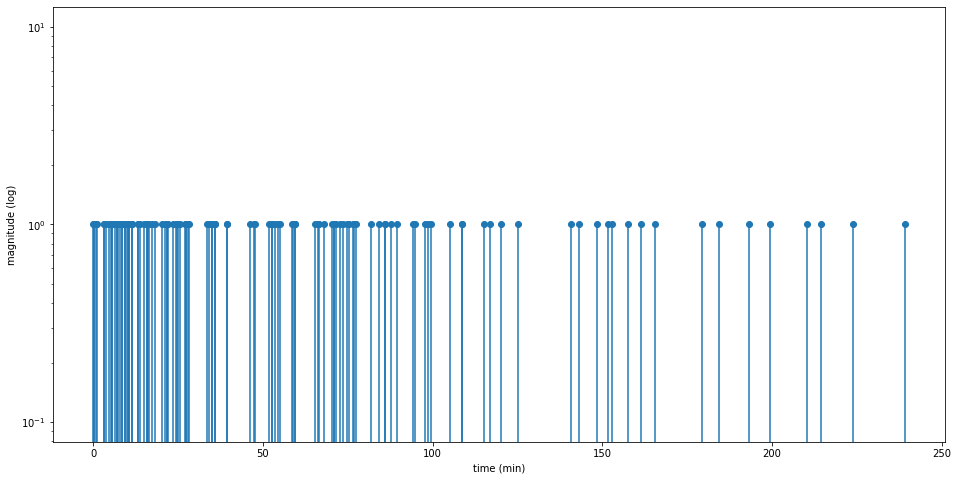

In [5]:
params = (0.1, 1/3600.)
lambda0 = 100
cascade = simulate_exp_hawkes_process(params, lambda0, max_size=10000)

print(f"{len(cascade)} points generated")
plot_cascade(cascade)

### Counting processes

*Counting processes* are an equivalent representation of *point processes*.  
As a reminder, counting process $\{ N_t \in \mathbb{N} | t \in \mathbb{R}^+ \}$ mapped to point process $\{ P_n \in \mathbb{R}^+ | n \in \mathbb{N}^*\}$ is defined as:

$$ N_t = \left| \, P_i \leq t \, | \, i \in \mathbb{N}^* \right| $$

> ** Question **:  
> Implement function ``counting_process`` as documented and plot the result


In [6]:
coef_Tmax = 1.1

def counting_process(cascade, T = None):
    """
    Returns a 2D-array N such that N(:,0) contains time samples t and N(:,1) contains images by point process N(t)
    
    cascade -- 2D-array containing samples of the point process as returned by simulate_exp_hawkes_process
    T       -- 1D array containing time samples whose value N(t) has to be computed (if None defines T to cover the full cascade)
    """
    
    tks = cascade[:,0]
    if T is None:
        Tmax = tks[-1] * coef_Tmax
        T = np.linspace(0,Tmax)
    N = np.zeros((len(T),2))
    N[:,0] = T
    for tk in tks:
        N[T >= tk,1] += 1
    return N

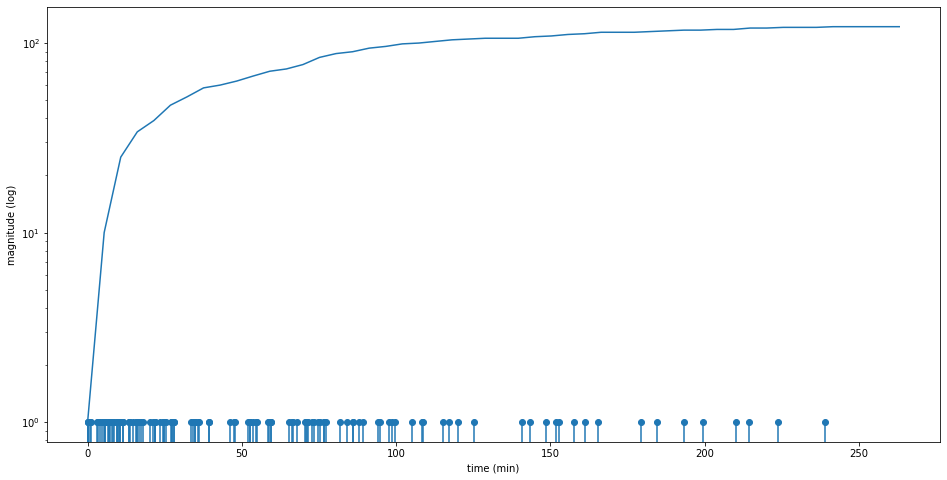

In [7]:
N = counting_process(cascade)
plot_cascade(cascade)
plt.plot(N[:,0]/60, N[:,1])

### Adaptation to marked exponential Hawkes processes

Now we consider the "marked" case where
 $$\lambda_+(t,m) = p \, m$$

One recalls that event magnitude $M$ has to be drawn from a power law distribution of parameters $\mu$ and $\alpha$, whose density is
$$
f_M(m) = \frac{\alpha-1}{\mu} \, \left(\frac{m}{\mu}\right)^{-\alpha}\, \mathbb{1}_{[\mu,+\infty[}(m) \quad .
$$
We choose different values as in [Mishra et al. 16], for stability purpose: instead, we take $\mu = 10$ and $\alpha = 2.3$.

Unfortunately numpy function ``np.random.power`` only draws samples from power-law with **positive** parameter.
One solution would be to draw samples $y$ from a $(+\alpha,1)$- power law distribution (i.e with opposite & positive parameter alpha) and then take $m = \frac{\mu}{y}$ (why would this work here?)

Instead we propose to use this limitation as an excellent opportunity to apply the *inverse transform sampling* technique we saw during the lectures: this technique consists in drawing a uniform sample *u* in the interval $[0,1]$ and apply to $u$ the inverse function $F_M^{-1}(u)$ of the cumulative distribution function $F_M(m) = P(M \leq m)$ of $M$. The resulting value $s$ is a sample of $M$.

> *** Question ***  
> Implement the ``neg_power_law`` function using this technique (use ``np.random.uniform(size)`` for this purpose).
> Check your function correctly works by comparing the histogram of many samples with the theoretical density function (you can use the provided code snippet).


In [8]:
def neg_power_law(alpha, mu, size=1):
    """
    Returns a 1D-array of samples drawn from a negative power law distribution
    
    alpha -- power parameter of the power-law mark distribution
    mu    -- min value parameter of the power-law mark distribution
    size  -- number of samples
    """
    
    u = np.random.uniform(size=size)
    return mu * np.exp(np.log(u) / (1. - alpha))


sample average = 41.45, expected value = 43.33


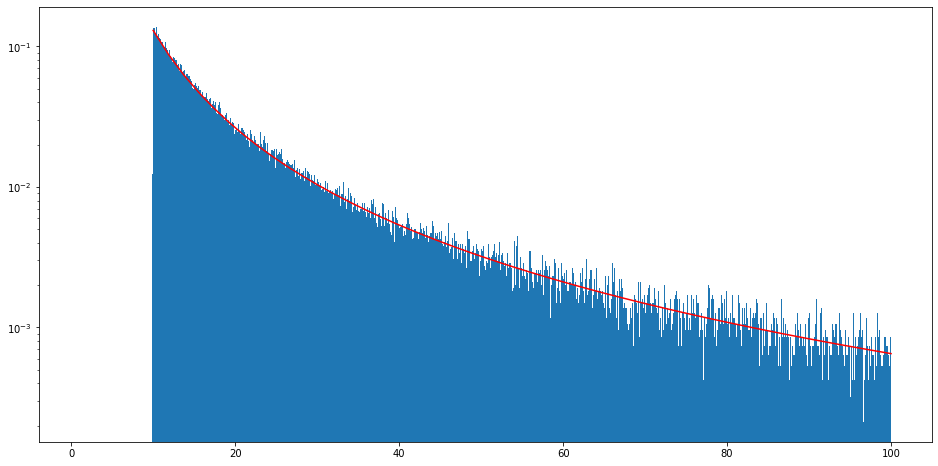

In [9]:
mu = 10; alpha = 2.3; 

# Draw samples 
samples = neg_power_law(alpha, mu, size=100000)

# Compare average with mean
print(f"sample average = {np.mean(samples):0.2f}, expected value = {mu * (alpha - 1)/(alpha - 2):0.2f}")

# Draw histogram
max_mark = 100
plt.hist(samples[samples < max_mark], range=(1,max_mark), bins=1000,density=True,log=True)

# Compare with theoretical density
m = np.linspace(mu,max_mark)
plt.plot(m, (alpha - 1) / mu * (m / mu) ** (-alpha), 'r')

> ** Question: **  
> Fill in function `simulate_marked_exp_hawkes_process` below by adapting `simulate_exp_hawkes_process` so that it simulates on a marked Hawkes process parameterized by $(p, \beta)$-exponential kernel and a $(\mu,\alpha)$-power law mark distribution. You will reuse your ``neg_power_law`` function.
>Then simulate and plot the process for different parameter values.

*Note:* *we will see later that the following condition must be verified for the process not to diverge*
 $$ n^* = p \, \mu \, \frac{\alpha - 1}{\alpha - 2} < 1$$
> ** Question: **  
> Observe what happens when you take parameter values so that $n^*$ gets smaller or larger than $1$.

In [10]:
def simulate_marked_exp_hawkes_process(params, m0, alpha, mu, max_size=10000):
    """
    Returns a 2D-array whose rows contain marked time points simulated from an exponential Hawkes process
    
    params   -- parameter tuple (p,beta) of the generating process
    m0       -- magnitude of the initial tweet at t = 0.
    alpha    -- power parameter of the power-law mark distribution
    mu       -- min value parameter of the power-law mark distribution
    max_size -- maximal authorized size of the cascade
    """
    
    p, beta = params    
    
    # Every row contains a marked time point (ti,mi).
    # Create an unitialized array for optimization purpose (only memory allocation)
    T = np.empty((max_size,2))
    
    intensity = beta * p * m0
    t, m = 0., m0
    
    # Main loop
    for i in range(max_size):
        # Save the current point before generating the next one.
        T[i] = (t,m)
        
        # 
        u = np.random.uniform()
        v = -np.log(u)
        w = 1. - beta / intensity * v
        # Tests if process stops generating points.
        if w <= 0.:
            T = T[:i,:]
            break
            
        # Otherwise computes the time jump dt and new time point t
        dt = - np.log(w) / beta
        t += dt
        
        # And update intensity accordingly
        m = neg_power_law(alpha, mu)
        lambda_plus = p * m
        intensity = intensity * np.exp(-beta * dt) + beta * lambda_plus        
    return T

n_star = 0.88
95 points generated


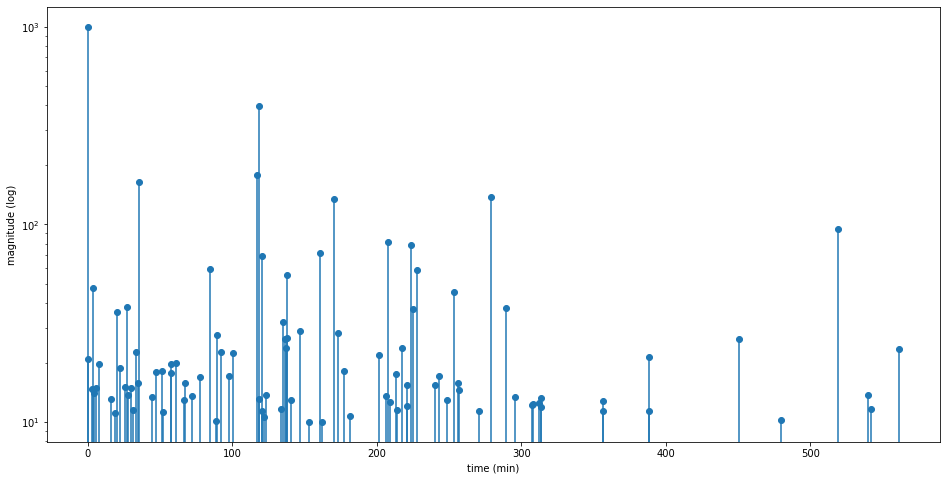

In [11]:
p, beta = 0.025, 1/3600.
alpha, mu = 2.4, 10
m0 = 1000
n_star = p * mu * (alpha - 1) / (alpha - 2)
print(f"n_star = {n_star:.2f}")
cascade = simulate_marked_exp_hawkes_process((p,beta), m0, alpha, mu, max_size=10000)

print(f"{len(cascade)} points generated")
plot_cascade(cascade)

# Analyzing marked Hawkes processes

To analyze the dynamics of a point process, it's first important to compute and plot its conditional intensity.
We recall that
$$\lambda^*(t) = \sum_{t_i < t} p \, m_i \, \beta \, \exp(-\beta \,(t-t_i))$$

> ** Question:**  
> Implement function `cond_intensity` to compute the intensity of a Hawkes process with exponential kernel given its parameters.

In [12]:
def cond_intensity(params, history, T):
    """
    Returns a numpy 2D-array containing the conditional intensity of an exponential Hawkes process
    (first column is time, second is mapped intensity)
    
    params   -- parameter tuple (p,beta) of the Hawkes process
    history  -- (n,2) numpy array containing marked time points (t_i,m_i)
    T        -- 1D-array containing the input times for which the intensity must be computed
    """
    
    p, beta = params    
    I = np.zeros((len(T),2))
    I[:,0] = T
                 
    # For every marked point,
    for ti,mi in history:
        # Get all time indexes whose time is greater than ti
        J = T >= ti
        # Update the intensity for all times larger thanti
        I[J,1] += mi * np.exp(-beta * (T[J]-ti))
        
    # Don't forget to multiply by p*beta
    I[:,1] *= p * beta
    return I

> **Question:**  
> Test by generating a cascade and then draw the resulting conditional intensity using the already implemented `draw_intensity` function.

In [13]:
def draw_intensity(params, history, Tmax = None, label = ""):
    """
    Draws an intensity plot along the history
    
    params   -- parameter tuple (p,beta) of the Hawkes process
    history  -- (n,2) numpy array containing marked time points (t_i,m_i)
    Tmax     -- upper bound of the plot interval
    label    -- legend label
    """

    if Tmax is None:
        Tmax = history[-1,0] * coef_Tmax
    T = np.linspace(-10., Tmax, 1000)
    I = cond_intensity(params, history, T)
    plt.plot(I[:,0] / 60., I[:,1] , label = label)
    plt.plot(history[:,0]/60, np.zeros(len(history)),'o', color='red')
    plt.title('Process intensity')
    plt.xlabel('Time (min)')

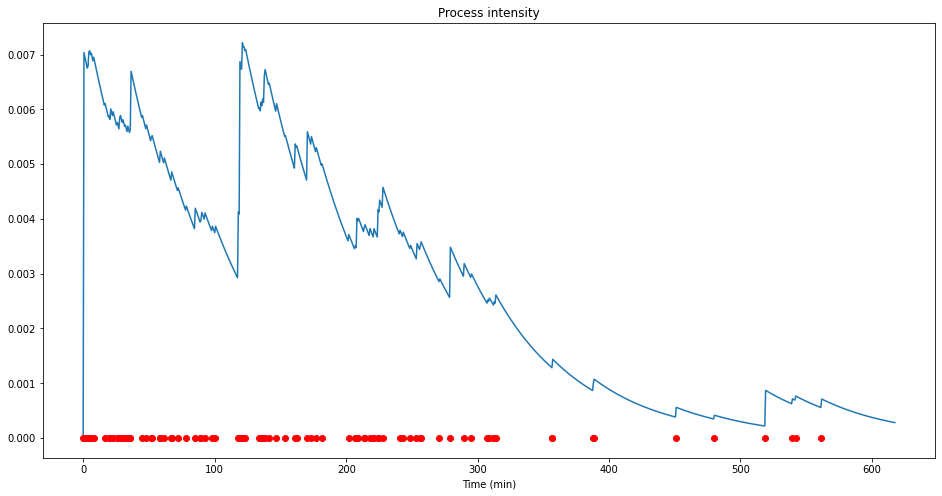

In [14]:
draw_intensity((p,beta), cascade)

To know the average number of generated points of a process given its conditional intensity, we just need to compute the cumulative intensity function
$$\Lambda(t) = \int_0^t \lambda^*(\tau) \, d\tau$$
Then the average number of points in an interval $[a,b]$ is just
$$\mathbb{E}(N(b) - N(a)) = \int_a^b \lambda^*(\tau) \, d\tau = \Lambda(b) - \Lambda(a)$$

> **Question:**  
> Complete function ``cumul_intensity`` to compute the cumulative intensity function  

**Indication:** *to compute the integral, you can either take a general approach (recommended) using function ``scipy.integrate.cumtrapz``, or you can compute the exact value of the integral specifically for exponential kernels.*

In [15]:
from scipy import integrate

def cumul_intensity(cond_intensity):
    """
    Returns a 2D array containing the cumulative intensity such that first column is time
    and second is mapped cumulative intensity up to given time.
 
    cond_intensity -- 2D-array as returned by cond_intensity function
    """
    
    T = cond_intensity[:,0]
    I = cond_intensity[:,1]
    
    C = np.empty_like(cond_intensity)
    C[:,0] = T
    C[:,1] = integrate.cumtrapz(I, T, initial=0)
    return C


> **Question:**  
> Check your function correctly works by drawing on the same plot the cumulative intensity (using the provided ``draw_cumul_intensity`` function) and the real counts (i.e given by computing the counting process N).
> You should observe that the cumulative intensity is more or less the counting process (some gaps can occur), but looks the same locally. Why is this?

In [16]:
def draw_cumul_intensity(params, history, Tmax=None, label=""):
    if Tmax is None:
        Tmax = history[-1,0] * coef_Tmax
    T = np.linspace(-10., Tmax, 1000)
    I = cond_intensity(params, history, T)
    cumul = cumul_intensity(I)
    plt.plot(cumul[:,0]/60., cumul[:,1], label=label)
    plt.xlabel('Time (min)')

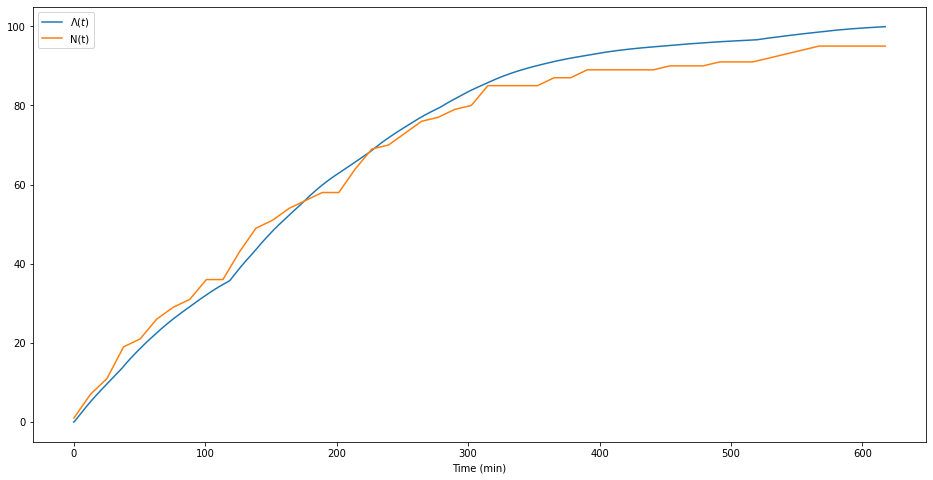

In [17]:
draw_cumul_intensity((p,beta), cascade, label='$\Lambda(t)$')
N = counting_process(cascade)
plt.plot(N[:,0]/60, N[:,1], label='N(t)')
plt.legend()

# Prediction

We now look at the problem of predicting at current time $t$ the total size $N_\infty(t)$ of a cascade given the parameters $(p,\beta)$ of the generating process and its history $\mathcal{H}_t = \{(m_1,t_1) \dots (m_n,t_n), T_{n+1} > t\}$, that is
$$
N_\infty(t) = \lim_{\tau \rightarrow +\infty} \mathbb{E}\left( N_{\tau}\, |\, \mathcal{H}_t \right) \quad .
$$
Now let's denote $G_k$ the number of points (i.e retweets) of the $k^{th}$ next generation:
* For $k=1$, the first generation are points generated by the $n$ past points observed in $\mathcal{H}_t$,
* For $k>1$, the $k^{th}$ generation are those generated by a point of the previous $(k-1)^{th}$ generation.

Then the expected total number of points is clearly:
$$
N_\infty(t) = n + \mathbb{E}\left(G_1\right) + \mathbb{E}\left(G_2\right) +  \mathbb{E}\left(G_3\right) \dots
$$

What is the relation between $\mathbb{E}\left(G_{k+1}\right)$ and $\mathbb{E}\left(G_k\right)$ for $k\geq 1$ ?

To answer this question, let consider point (i.e retweet) number $i$ of the $k^{th}$ generation and let denote $N^{(k)}_i$ the number of points of the ${k+1}^{th}$ generation whose parent is $i$. Then
$$
\mathbb{E}\left(G_{k+1} \, |\, G_k = g \right) = \mathbb{E}\left(\sum_{i=1}^{g} N^{(k)}_i \, \middle|\, G_k = g \right) = \sum_{i=1}^{g} \mathbb{E}\left( N^{(k)}_i \right)
$$
Assuming all $N^{(k)}_i$ are indenpendent and identically distributed given their magnitude (this is a very coarse hypothesis, why?), we get:
$$
\mathbb{E}\left( N^{(k)}_i \right) = \mathbb{E}\left( N^{(k)} \, |\, M \right) = \int_1^{+\infty} \mathbb{E}\left( N^{(k)} \, |\, M = m\right)  \, P_M(m) \, dm
$$
Quantity $\mathbb{E}\left( N^{(k)} | M = m\right)$ is the average number of points generated by one given point of generation $k$ and magnitude $m$. Its value is given by integrating the partial intensity due to this single point. Assuming the point occurs at $t=t_i$, we get:
$$
\begin{align}
\mathbb{E}\left( N^{(k)} \, |\, M = m\right)& = \int_{t_i}^{+\infty} p \, m \, \phi(t-t_i) \, dt\\
& = p \,m
\end{align}
$$
Replacing,
$$
\begin{align}
\mathbb{E}\left( N^{(k)}_i \right) & = \int_1^{+\infty} p \, m \, P_M(m) \, dm\\
& = p \, \mathbb{E}\left(M\right)
\end{align}
$$
So
$$
\mathbb{E}\left(G_{k+1} \, |\, G_k = g\right) = p \, \mathbb{E}\left(M\right) \, g
$$
Finally
$$
\begin{align}
\mathbb{E}\left(G_{k+1}\right) & = \int_0^{+\infty} \mathbb{E}\left(G_{k+1} \, |\, G_k = g\right) \, P_{G_k}(g) \, dg \\
& = \int_0^{+\infty} p \, \mathbb{E}\left(M\right) \, g \, P_{G_k}(g) \, dg \\
& = p \, \mathbb{E}\left(M\right) \, \mathbb{E}\left(G_k\right) \\
& = n^* \, \mathbb{E}\left(G_k\right) \text{ with } n^* = p \, \mathbb{E}\left(M\right)
\end{align}
$$
Therefore $(\mathbb{E}\left(G_k\right))$ is a geometric sequence and
$$
\mathbb{E}\left(G_k\right) = {\left(n^*\right)}^{k-1} \, \mathbb{E}\left(G_1\right)
$$

The number denoted $n^*$ is called the **branching factor** of the self-exciting process. 
It is the number of points generated on average by a single point. As we can see, the global process behaves as if all points had a constant branching factor.

**Note:** *this number is at the heart of the very hot COVID-19 topic: in the field of epidemiology, the branching factor is also called the *reproduction number $R$*, defined as the average number of people that catch the virus from one single person.*

If $n^* \geq 1$, obviously the sequence $G_k$ is positive non decreasing so that $N_\infty(t) = +\infty$.
Otherwise the expected total number of points is:
$$
\begin{align}
N_\infty(t) & = n + G_1 + G_2 + G_3 \dots \\
& = n + G_1 + n^* \, G_1 + {n^*}^2 \, G_1 + \dots \\
& = n + \frac{G_1}{1 - n^*}\\
& = n + \frac{G_1}{1 - p \, \mathbb{E}\left(M\right)}
\end{align}
$$
The two remaining unknowns are thus $G_1$ and $\mathbb{E}\left(M\right)$.
The latter is easy to compute:
$$
\mathbb{E}\left(M\right)  = \int_\mu^{+\infty} \frac{\alpha - 1}{\mu} \, \left(\frac{m}{\mu}\right)^{-\alpha}\, m \, dm = \frac{\alpha - 1}{\alpha - 2}\, \mu
$$
Since all cascades are assumed to be finite, the constraint $n^* < 1$ enforces the condition
$$
p \, \mu < \frac{\alpha - 2}{\alpha - 1} \quad .
$$
The value of $G_1$ is given by
$$
\begin{align}
G_1 & = \Lambda(+\infty) - \Lambda(t) = \int_t^{+\infty} \lambda^*(t) \, dt \\
& = \int_t^{+\infty}  \sum_{i=1}^n p \, m_i \, \beta \, \exp(- \beta \, (t - t_i)) \, dt \\
& = p \, \sum_{i=1}^n \, m_i \, \exp(- \beta \, (t - t_i)) \quad .
\end{align}
$$
To summarize,
$$
N_\infty(t) = n + \frac{p \, \sum_{i=1}^n \, m_i \, \exp(- \beta \, (t - t_i))}{1 - n^*} \text{ with } n^* = p \, \mu \, \frac{\alpha - 1}{\alpha - 2} < 1
$$


> **Question: **  
> Complete function ``prediction()`` that predicts given the parameters of the process and its history, the total size of a cascade for one single given time $t$.

**Warning: at time $t$, the sum in expression of $G_1$ is computed only on points $(t_i,m_i)$ such that $t_i < t$.**

In [18]:
def prediction(params, history, alpha, mu, t):
    """
    Returns the expected total numbers of points for a set of time points
    
    params   -- parameter tuple (p,beta) of the Hawkes process
    history  -- (n,2) numpy array containing marked time points (t_i,m_i)  
    alpha    -- power parameter of the power-law mark distribution
    mu       -- min value parameter of the power-law mark distribution
    t        -- current time (i.e end of observation window)
    """

    p,beta = params
    
    tis = history[:,0]
   
    EM = mu * (alpha - 1) / (alpha - 2)
    n_star = p * EM
    if n_star >= 1:
        raise Exception(f"Branching factor {n_star:.2f} greater than one")
    n = len(history)

    I = history[:,0] < t
    tis = history[I,0]
    mis = history[I,1]
    G1 = p * np.sum(mis * np.exp(-beta * (t - tis)))
    Ntot = n + G1 / (1. - n_star)
    return Ntot

> **Question: **  
> As a facility, complete function  ``predictions()`` that predicts given the parameters of the process and its history, the total size of a cascade for a set of current times (provided by a 1D-array $T$).  

*Indication: the code provided for ``predictions()`` in the correction is optimized but a naive implementation is fine: just compute in one internal function the prediction for one single time according to the given expression above, and then call this function for every time in $T$.*

**Warning: at time $t$, the sum in expression of $G_1$ is computed only on points $(t_i,m_i)$ such that $t_i < t$.**

In [19]:
def predictions(params, history, alpha, mu, T = None):
    """
    Returns the expected total numbers of points for a set of time points
    
    params   -- parameter tuple (p,beta) of the Hawkes process
    history  -- (n,2) numpy array containing marked time points (t_i,m_i)  
    alpha    -- power parameter of the power-law mark distribution
    mu       -- min value parameter of the power-law mark distribution
    T        -- 1D-array of times (i.e ends of observation window)
    """

    p,beta = params
    
    tis = history[:,0]
    if T is None:
        T = np.linspace(60,tis[-1],1000)

    N = np.zeros((len(T),2))
    N[:,0] = T
    
    EM = mu * (alpha - 1) / (alpha - 2)
    n_star = p * EM
    if n_star >= 1:
        raise Exception(f"Branching factor {n_star:.2f} greater than one")
    n = len(history)

    Si, ti_prev, i = 0., 0., 0
    
    for j,t in enumerate(T):
        
        for (ti,mi) in history[i:]:
            if ti >= t:
                break
            else:
                Si = Si * np.exp(-beta * (ti - ti_prev)) + mi
                ti_prev = ti
                i += 1
                
        G1 = p * Si * np.exp(-beta * (t - ti_prev))
        N[j,1] = n + G1 / (1. - n_star)
    return N

> **Question:**  
> Test your prediction functions by generating a cascade from a process with known parameters.
> Then plot the time evolution of the size prediction along with the counting process.
> Test for the different parameters and see how predictions vary...

In [20]:
p, beta = 0.02, 1/3600.
alpha, mu = 2.4, 10

EM = mu * (alpha-1)/(alpha-2)
print(f"Branching factor n* = {p * EM:.2f}")
if p * EM >= 1:
    raise Exception(f"p must be less than {1/EM:.2f}")

cascade = simulate_marked_exp_hawkes_process((p,beta), m0, alpha, mu)

print(f"               E(M) = {EM:.2f} avg(mi) = {np.mean(cascade[1:,1]):.2f}")
print(f"                  n = {len(cascade)}")


Branching factor n* = 0.70
               E(M) = 35.00 avg(mi) = 22.76
                  n = 22


Prediction at 50 min = 61


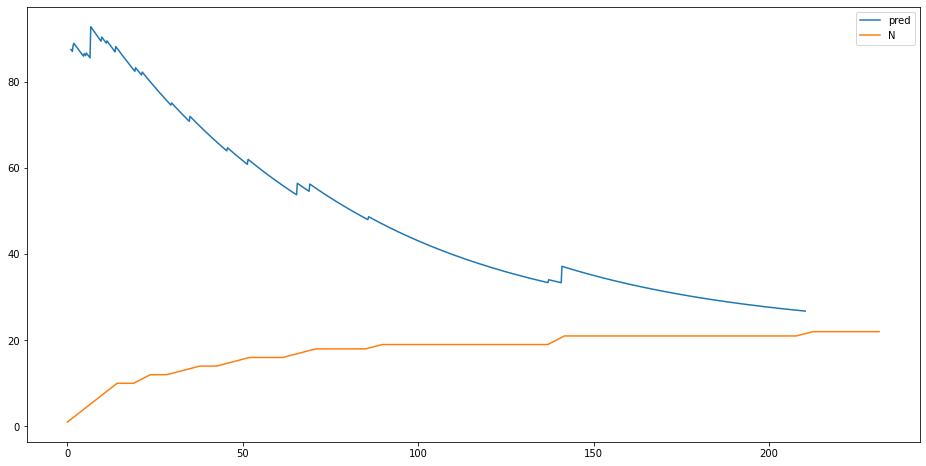

In [21]:
tmin = 50
pred = prediction((p,beta), cascade, alpha, mu,tmin * 60)
print(f"Prediction at {tmin} min = {int(pred)}")

preds = predictions((p,beta), cascade, alpha, mu)
plt.plot(preds[:,0]/60,preds[:,1], label='pred')
N = counting_process(cascade)
plt.plot(N[:,0]/60, N[:,1], label='N')
plt.legend()

As you can see, even when knowing perflectly the parameters of a generative model, prediction is a very hard problem, especially for short observation windows.
This is a general fact in prediction problems where given some past & present, there is generally a huge number of possible and strongly different futures.

Now that we have gathered all the basic ingredients to simulate, plot and predict Hawkes processes, time has come to look at parameter estimation.


# Computing MLE

The roadmap is to compute the *likelihood* $\mathcal{L}(\theta)$ of a process given the available observations in some time window $[0,t]$ and then to compute the *maximum likelihood estimator (MLE)*, i.e parameters $\hat{\theta}_{MLE}$ that maximize likelihood using some optimization algorithm (gradient ascent, Newton-Raphson, etc).

##  Computing likelihood

The first step is to compute the likelihood.
During the lectures, we showed that the likelihood of an unmarked point process with respect to its history $\mathcal{H}_t = \{ (t_i)_{1 \leq i \leq n} \, | \, t_i \leq t\}$ is:
$$
\mathcal{L}_u(\theta)  = P(\mathcal{H}_t \, | \, \theta) = \left( \prod_{i=1}^n \lambda^*(t_i) \right) \, \exp(-\Lambda(t))$$
However here we choose always the time reference so that $t_1 = 0$. Consequently here
$$
\mathcal{L}_u(\theta)  = P(\mathcal{H}_t \, | \, \theta) 
 = \left( \prod_{i=2}^n \lambda^*(t_i) \right) \, \exp(-\Lambda(t))
$$

Now let's consider our problem that includes marks:
given history $\mathcal{H}_t = \{(t_i,m_i)_{1 \leq i \leq n} \, | \, t_i \leq t\}$, and given the fact $\alpha$ is a predetermined constant, the likelihood $\mathcal{L}_m$ can be decomposed in two independent factors:
$$
\begin{align}
\mathcal{L}_m(\theta) & = P(\mathcal{H}_t \, | \, \theta, \alpha) \\
& = P((t_i)_{1 \leq i \leq n} \, | \, \theta, \alpha) \times P((m_i)_{1 \leq i \leq n} \, | \, (t_i)_{1 \leq i \leq n} \, \theta, \alpha) \\
& = P((t_i)_{1 \leq i \leq n} \, | \, \theta) \times \prod_{i=1}^n P(m_i \, | \, \alpha) \\
& = \mathcal{L}_u(\theta) \times cst.
\end{align}
$$

We see that observed magnitudes $m_i$ have no influence on the choice of parameters $\theta$ so that we can consider that the likelihood is just $\mathcal{L}(\theta) = \mathcal{L}_u(\theta)$.

> **Question:**  
> Simplify the expression of the loglikelihood in case of a Hawkes process with exponential kernel parameterized by $\theta = (p,\beta)$ and show this is equal to
> $$\log\mathcal{L}(\theta) = (n-1) \, \log(p\, \beta) + \sum_{i=2}^n \log\left(\sum_{j=1}^{i-1} m_j \, \exp\left(-\beta \,(t_i-t_j)\right)\right) - p \,\left(\sum_{i=1}^n m_i \, \left(1 - \exp \left(-\beta(t - t_i)\right)\right)\right) $$

> **Question:**  
> Implement this expression in function ``naive_loglikelihood``. What is the time complexity with respect to $n$?

In [22]:
def naive_loglikelihood(params, history, t):
    """
    Returns the loglikelihood of a Hawkes process with exponential kernel
        
    params   -- parameter tuple (p,beta) of the Hawkes process
    history  -- (n,2) numpy array containing marked time points (t_i,m_i)  
    t        -- current time (i.e end of observation window)
    """
    
    p,beta = params    
    n = len(history)
    tis = history[:,0]
    mis = history[:,1]
    
    LL = (n-1) * np.log(p * beta)
    
    for i in range(1,n):      
        LL += np.log(np.sum(mis[:i] * np.exp(-beta * (tis[i] - tis[:i]))))
        
    LL -= p * np.sum(mis * (1. - np.exp(-beta * (t - tis))))

    return LL

To check this function behaves as expected, we can test it on a large cascade (why do we need a large cascade?). 
We provide function ``evaluate_likelihood_of_params`` for this purpose.
Understand what it does and use it on a large cascade. 
Check you obtain the expected results.

*Be careful: likelihood is here a density, not a probability (i.e might be greater than 1)*


In [23]:
def evaluate_likelihood_of_params(params, cascade, t, ratio = 0.7):
    n = len(cascade)
    print(f"Number of samples = {n}")
    print("Average likelihoods per sample:")
    def test_params(p):
        LL = naive_loglikelihood(p, cascade, t)
        print(f"  {np.exp(LL /n):0.7f} for (p,beta)=({p[0]:0.3f},{p[1]:0.5f})")
    
    test_params(params)
    test_params((params[0] * ratio, params[1]))
    test_params((params[0] / ratio, params[1]))
    test_params((params[0], params[1] * ratio))
    test_params((params[0], params[1] / ratio))

In [24]:
p, beta = 0.025, 1/3600.
alpha, mu = 2.4, 10
cascade = simulate_marked_exp_hawkes_process((p,beta), m0, alpha, mu)
print(f"n = {len(cascade)}")

n = 423


In [25]:
t = cascade[-1,0]
n = len(cascade)

evaluate_likelihood_of_params((p,beta), cascade, t)

Number of samples = 423
Average likelihoods per sample:
  0.0028196 for (p,beta)=(0.025,0.00028)
  0.0026255 for (p,beta)=(0.017,0.00028)
  0.0026805 for (p,beta)=(0.036,0.00028)
  0.0028204 for (p,beta)=(0.025,0.00019)
  0.0027691 for (p,beta)=(0.025,0.00040)


## Computation issues

Now let's evaluate how costly it is to compute likelihood. To do so we use a provided generic test function ``evaluate_processing_time`` to measure processing times for various number of samples.

> **Question: **  
> Evaluate the algorithm using the provided code snipet and then plot the processing time versus the number of samples to determine the empirical complexity and compare it with the theoretical one.

In [26]:
import timeit

def evaluate_processing_time(target, preprocessing, sizes):
    """
    Returns a dataframe containing the processing time to evaluate a function for varying input size
    
    target        -- function to evaluate, taking as inputs the output of the preprocessing function
    preprocessing -- function that generates inputs from a given size
    sizes         -- range of sizes for which target functio has to be evaluated
    """
    
    times = np.zeros((len(sizes),2))
    
    for i,n in enumerate(sizes):
        
        print(f"Preprocessing size {n}...")
        inputs = preprocessing(n)
        
        print(f"Test size {n}")        
        test = timeit.Timer(lambda : target(inputs))
        times[i] = [n, np.mean(test.timeit(1))]

    return pd.DataFrame(times, columns=['size','time'])

In [27]:
p, beta = 0.04, 1/3600.
alpha, mu = 2.4, 10
m0 = 1000
n_star = p * mu * (alpha - 1) / (alpha - 2)
print(f"n_star = {n_star:.2f}")
if n_star < 1:
    raise Exception("Branching factor must be greater than 1 for this test")
   
preprocessing_function = lambda n : simulate_marked_exp_hawkes_process((p,beta), m0, alpha, mu, max_size=n)
function_to_evaluate = lambda cascade : naive_loglikelihood(params, cascade, cascade[-1,0])
sizes = [ 100,1000,10000,50000]

perf_naive = evaluate_processing_time(function_to_evaluate, preprocessing_function, sizes)
perf_naive.head()


n_star = 1.40
Preprocessing size 100...
Test size 100
Preprocessing size 1000...
Test size 1000
Preprocessing size 10000...
Test size 10000
Preprocessing size 50000...
Test size 50000


,size,time
0,100.0,0.000855
1,1000.0,0.012614
2,10000.0,0.393685
3,50000.0,7.835467


<AxesSubplot:xlabel='size'>

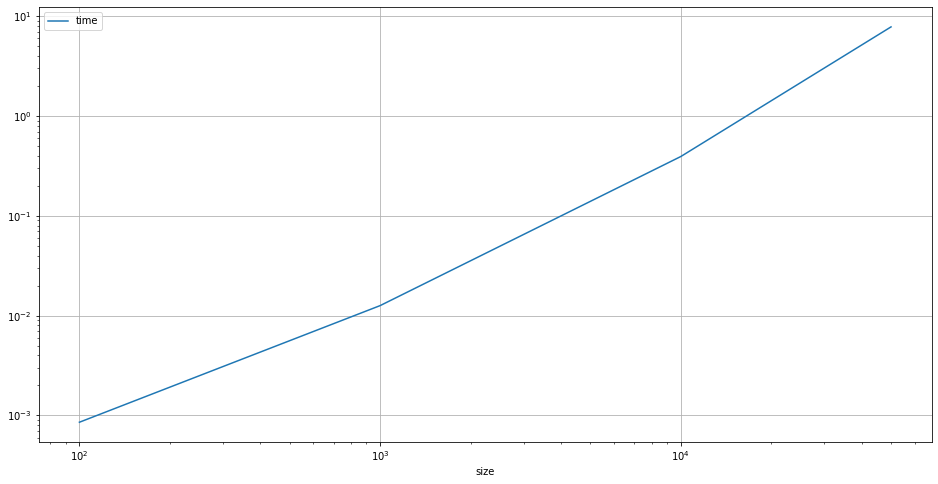

In [28]:
perf_naive.plot('size', 'time', logx=True, logy=True, grid=True)

## Fast computation of likelihood

We now want to leverage the specific properties of the exponential kernel to derive a faster algorithm to compute loglikelihood.
$$\log\mathcal{L}(\theta) = (n-1) \, \log(p\, \beta) + \sum_{i=2}^n \log\left(\sum_{j=1}^{i-1} m_j \, \exp\left(-\beta \,(t_i-t_j)\right)\right) - p \,\left(\sum_{i=1}^n m_i \, \left(1 - \exp \left(-\beta(t - t_i)\right)\right)\right) $$

To do so, observe the quadratic complexity comes from the term
$$\sum_{i=2}^n \log\left(\sum_{j=1}^{i-1} m_j \, \exp\left(-\beta \,(t_i-t_j)\right)\right)$$

> **Question:**  
> Introducing the sequence $(A_i)$ defined as
> $$
\begin{align}
& A_0 = 0 \\
\forall i \in \{1 \dots n\}, & A_i = \sum_{j=1}^{i-1} m_j \, \exp\left(-\beta \,(t_i-t_j)\right) \\
& A_{n+1} = \sum_{j=1}^{n} m_j \, \exp\left(-\beta \,(t-t_j)\right)
\end{align}
$$
> find a recursive formula that computes $A_i(\beta)$ from $A_{i-1}(\beta)$ in constant time, assuming $A_0 = 0$.



$$
\begin{align}
A_i & = \sum_{j=1}^{i-1} m_j \, \exp\left(-\beta \,(t_i-t_j)\right) \\
& = \exp\left(-\beta \,(t_i-t_{i-1})\right) \, \left(m_{i-1} + \sum_{j=1}^{i-2} m_j \, \exp\left(-\beta \,(t_{i-1}-t_j)\right) \right) \\
& = \exp\left(-\beta \,(t_i-t_{i-1})\right) \, \left(m_{i-1} + A_{i-1} \right)
\end{align}
$$

> **Question:**  
> Rewriting loglikelihood as function of terms $(A_i)_{1\leq i \leq n+1}$, implement in function ``loglikelihood`` a algorithm that computes with a linear complexity thanks to the recursive relation the loglikelihood $\log\mathcal{L}(\theta)$.

$$\log\mathcal{L}(\theta) = (n-1) \, \log(p\, \beta) + \sum_{i=2}^n \log\left(A_i\right) - p \,\left(\sum_{i=1}^n m_i - A_{n+1} \right) $$


In [29]:
def loglikelihood(params, history, t):
    """
    Returns the loglikelihood of a Hawkes process with exponential kernel
    computed with a linear time complexity
        
    params   -- parameter tuple (p,beta) of the Hawkes process
    history  -- (n,2) numpy array containing marked time points (t_i,m_i)  
    t        -- current time (i.e end of observation window)
    """
    
    p,beta = params    
    
    if p <= 0 or p >= 1 or beta <= 0.: return -np.inf

    n = len(history)
    tis = history[:,0]
    mis = history[:,1]
    
    LL = (n-1) * np.log(p * beta)
    logA = -np.inf
    prev_ti, prev_mi = history[0]
    
    i = 0
    for ti,mi in history[1:]:
        if(prev_mi + np.exp(logA) <= 0):
            print("Bad value", prev_mi + np.exp(logA))
        
        logA = np.log(prev_mi + np.exp(logA)) - beta * (ti - prev_ti)
        LL += logA
        prev_ti,prev_mi = ti,mi
        i += 1
        
    logA = np.log(prev_mi + np.exp(logA)) - beta * (t - prev_ti)
    LL -= p * (np.sum(mis) - np.exp(logA))

    return LL

> **Question:**  
> Test function ``loglikelihood`` by comparing the result with the one returned by ``naive_loglikelihood``.

In [30]:
p, beta = 0.04, 1/3600.
alpha, mu = 2.4, 10
m0 = 1000
cascade = simulate_marked_exp_hawkes_process((p,beta), m0, alpha, mu)
t = cascade[-1,0]
n = len(cascade)

LL1 = naive_loglikelihood(params, cascade, t)
LL2 = loglikelihood(params, cascade, t)

print(f"quadratic loglikelihood per sample = {LL1/n}")
print(f"   linear loglikelihood per sample = {LL2/n}")

quadratic loglikelihood per sample = -2.4316149375163
   linear loglikelihood per sample = -2.4316149375162857


> **Question:**  
> Compare the empirical complexity of ``loglikelihood`` and ``naive_loglikelihood``.  
> Verify that the complexity of ``loglikelihood`` is linear.

In [31]:
p, beta = 0.04, 1/3600.
alpha, mu = 2.4, 10
m0 = 1000
n_star = p * mu * (alpha - 1) / (alpha - 2)
print(f"n_star = {n_star:.2f}")
if n_star < 1:
    raise Exception("Branching factor must be greater than 1 for this test")

preprocessing_function = lambda n : simulate_marked_exp_hawkes_process((p,beta), m0, alpha, mu, max_size=n)
function_to_evaluate = lambda cascade : loglikelihood(params, cascade, cascade[-1,0])
sizes = [ 100,1000,10000,50000]

perf_optim = evaluate_processing_time(function_to_evaluate, preprocessing_function, sizes)
perf_optim.head()

n_star = 1.40
Preprocessing size 100...
Test size 100
Preprocessing size 1000...
Test size 1000
Preprocessing size 10000...
Test size 10000
Preprocessing size 50000...
Test size 50000


,size,time
0,100.0,0.000401
1,1000.0,0.003800
2,10000.0,0.039184
3,50000.0,0.181799


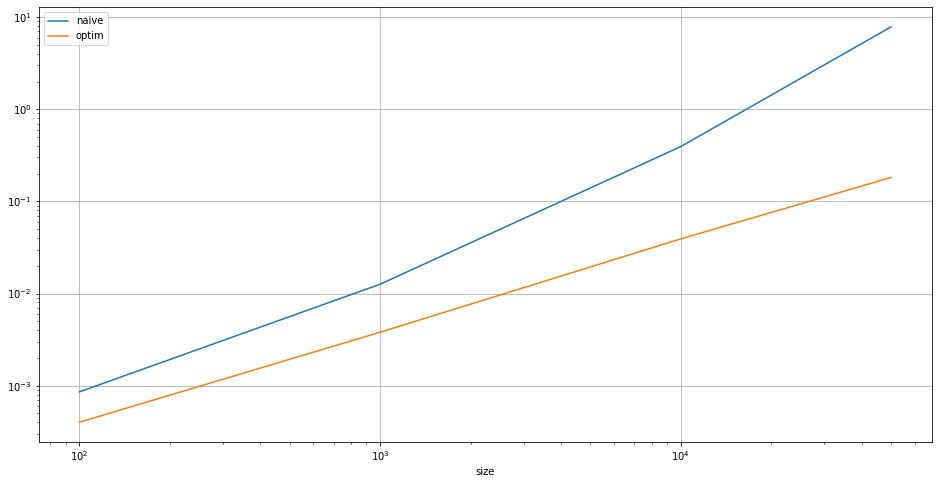

In [32]:
ax = perf_naive.plot('size', 'time', logx=True, logy=True, grid=True)
perf_optim.plot('size', 'time', logx=True, logy=True, grid=True, ax=ax)
plt.legend(['naive', 'optim'])

## Computing MLE

Given a cascade and its history $\mathcal{H}_t$ up to time $t$ ($t$ is the lengtho of the observation window), we now search for parameters $\hat{\theta}_{MLE} = (\hat{p}_{MLE},\hat{\beta}_{MLE})$ that maximizes $\log\mathcal{L}(\theta) = \log P(\mathcal{H}_t \, | \, \theta)$. One necessary condition is that the gradient is zero:
$$\frac{\partial \log\mathcal{L}}{\partial p}(\hat{\theta}_{MLE}) = \frac{\partial \log\mathcal{L}}{\partial \beta}(\hat{\theta}_{MLE}) = 0$$
where
$$\log\mathcal{L}(\theta) = (n-1) \, \log(p\, \beta) + \sum_{i=2}^n \log\left(\sum_{j=1}^{i-1} m_j \, \exp\left(-\beta \,(t_i-t_j)\right)\right) - p \,\left(\sum_{i=1}^n m_i \, \left(1 - \exp \left(-\beta(t - t_i)\right)\right)\right) $$
The gradient is
$$
\begin{align}
\frac{\partial \log\mathcal{L}}{\partial p}(p,\beta) & = \frac{n-1}{p} - \sum_{i=1}^n m_i \, \left(1 - \exp \left(-\beta(t - t_i)\right)\right) \\
\frac{\partial \log\mathcal{L}}{\partial \beta}(p,\beta) & = \frac{n-1}{\beta} - \sum_{i=2}^n \frac{\sum_{j=1}^{i-1} m_j \, (t_i - t_j) \, \exp\left(-\beta \,(t_i - t_j)\right)}{\sum_{j=1}^{i-1} m_j \, \exp\left(-\beta \,(t_i-t_j)\right)} - p \,\left(\sum_{i=1}^n m_i \, (t - t_i) \, \exp \left(-\beta(t - t_i)\right) \right) 
\end{align}
$$

> **Question:**  
> Check the expression of the gradient given above. Is it possible to get MLE as a closed-form expression?



### Computing MLE using an optimization method

Since we do not have a closed-form solution we have to compute an approximate solution using some optimization algorithm.

The optimization problem is formally
> $\mathtt{Given~} \mathcal{H}_t, \, \mathtt{minimize} \log\mathcal{L}_t\left((p,\beta)\right) \, \mathtt{~wih~} p \in \left]0, \frac{1}{\mathbf{E}(M)}\right[ \text{ and }\beta \in ]0, +\infty[$

This is a multivariate (i.e defined in $\mathbb{R}^2$) optimization problem with bounds (i.e domains of $p$ and $\beta$ are not $\mathbb{R}$ but restricted subsets) and no additionnal constraint.

Many algorithms have been developped in different optimization libraries to solve multivariate optimization problems, with our without constraints, with or without specific shapes for the target function and/or constraints, etc. Authors of the CIKM16 paper used library ``IPOPT`` on power-law kernels with four bounded parameters and an additional constraint. We will use simply the standard ``scipy.optimize`` library as our optimization problem is relatively elementary and with a low dimension of two.

In general for high dimensional problems (constrained our not), one has to resort to "local optimization techniques" using either first-order derivation (i.e gradient of target function and Jacobian of constraints) or sometimes second-order derivatives (i.e Hessian matrix of the target function). These techniques can be seen as improvements of the gradient ascent/descent (first order) or Newton-Raphson (second order) algorithms, that integrate additional constraints and bounds.

The normal roadmap would thus be to derive the expression of the gradient and even the Hessian matrix of our likelihood function and to use one of these algorithms.
However this would require some times to derive these expression and to find an optimized algorithm to compute it as we did for the likelihood function.

Since these derivations are error-prone, we propose to avoid this tedious work as we work on a very low dimensional space of the couple $(p,\beta)$. In such case (and only in this case), we can use methods that only need to evaluate the target function to optimize (here the loglikelihood) without computing derivatives.

Methods of the library ``scipy.optimize`` are listed in the documentation page of function
[optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize).
Among them, two methods are proposed that do not require derivatives:
* [Nelder-Mead's method](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method) shrinks an elementary volume (i.e a simplex) towards a local optimum.
* [Powell's method](https://en.wikipedia.org/wiki/Powell%27s_method) finds iteratively the local optimum by moving along some frame axes and then by updating these frame axes by inserting the best direction found at every step.

In ``scipy.optimize``, Powell's method accepts bounds on variables where s Nelder-Mead's one does not.
We therefore choose Powell's method.

> **Question:**  
> Complete function ``compute_MLE`` to find MLE using Powell's method 
> after reading the documentation of [scipy.optimize.minimize(method=’Powell’)](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-powell.html)  

> **Note:** *Do not forget that we want to MAXIMIZE loglikelihood where the standard assumption of optimization libraries is to MINIMIZE functions.*


In [33]:
import scipy.optimize as optim

def compute_MLE(history, t, alpha, mu,
                init_params=np.array([0.0001, 1./60]), 
                max_n_star = 1., display=False):
    """
    Returns the pair of the estimated loglikelihood and parameters (as a numpy array)

    history     -- (n,2) numpy array containing marked time points (t_i,m_i)  
    t           -- current time (i.e end of observation window)
    alpha       -- power parameter of the power-law mark distribution
    mu          -- min value parameter of the power-law mark distribution
    init_params -- initial values for the parameters (p,beta)
    max_n_star  -- maximum authorized value of the branching factor (defines the upper bound of p)
    display     -- verbose flag to display optimization iterations (see 'disp' options of optim.optimize)
    """
    
    # Define the target function to minimize as minus the loglikelihood
    target = lambda params : -loglikelihood(params, history, t)
    
    EM = mu * (alpha - 1) / (alpha - 2)
    eps = 1.E-8

    # Set realistic bounds on p and beta
    p_min, p_max       = eps, max_n_star/EM - eps
    beta_min, beta_max = 1/(3600. * 24 * 10), 1/(60. * 1)
    
    
    # Define the bounds on p (first column) and beta (second column)
    bounds = optim.Bounds(
        np.array([p_min, beta_min]),
        np.array([p_max, beta_max])
    )
    
    # Run the optimization
    res = optim.minimize(
        target, init_params,
        method='Powell',
        bounds=bounds,
        options={'xtol': 1e-8, 'disp': display}
    )
    
    # Returns the loglikelihood and found parameters
    return(-res.fun, res.x)

> **Question:**  
> Test ``compute_MLE`` by generating a sufficiently long cascade from a known parameterized model, compute the likelihood of the cascade and compare with the returned MLE likelihood and parameters.
> Observe what happens when the number of samples is small.

In [34]:
def get_new_cascade(m0, p, beta, alpha, mu):
    n_star = p * mu * (alpha - 1) / (alpha - 2)
    if n_star < 1:
        cascade = simulate_marked_exp_hawkes_process((p,beta), m0, alpha, mu)
        n = len(cascade)
        print(f"         n = {n}")
        t = cascade[-1,0]

        LL = loglikelihood((p, beta), cascade, t)
        LL_MLE,MLE = compute_MLE(cascade, t, alpha, mu)
        p_MLE, beta_MLE = MLE
        n_star_MLE = p_MLE * mu * (alpha - 1) / (alpha - 2)  
        rel_error = (np.abs(p_MLE - p) + np.abs(beta_MLE - beta) / beta)/2.

        print(f"        LL = {LL/n:.4f} MLE = {LL_MLE/n:.4f}")
        print(f"         p = {p:.5f} MLE = {p_MLE:.5f}")
        print(f"      beta = {beta:.5f} MLE = {beta_MLE:.5f}")
        print(f"    n_star = {n_star:.5f} MLE = {n_star_MLE:.5f}")
        print(f"rel. error = {rel_error:.2f}")
        return cascade
    else:
        print(f"** Failure: n_star = {n_star:.2f} greater than 1 **")
        return None

In [35]:
p, beta = 0.02, 1/3600.
alpha, mu = 2.4, 10
m0 = 1000        
cascade = get_new_cascade(m0, p, beta, alpha, mu)

         n = 82
        LL = -6.7762 MLE = -6.7697
         p = 0.02000 MLE = 0.02230
      beta = 0.00028 MLE = 0.00026
    n_star = 0.70000 MLE = 0.78037
rel. error = 0.04


/usr/lib/python3/dist-packages/scipy/optimize/_minimize.py:515: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
/usr/lib/python3/dist-packages/scipy/optimize/optimize.py:1975: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Now we combine parameter estimation with prediction.

> **Question:**  
> Using function ``predictions_from_estimator`` that makes prediction according to some estimators like MLE, plots the estimated prediction according to MLE along with the estimated prediction using the true parameter values and the counting process. What do you observe in term of variance and computation time?

In [36]:
def predictions_from_estimator(estimator, history, alpha, mu, T=None, n_tries=1, slider=True):
    """
    Compute the provided estimator for different observation windows and apply prediction according to it. Returns
    * the expected total numbers of points for a set of time points as a 1D-array
    * the computed loglikelihoods as a 1D-array
    * the estimated parameters as a 2D-array
    
    estimator -- function that implements an estimator that expect the same arguments as compute_MLE
    history   -- (n,2) numpy array containing marked time points (t_i,m_i)  
    alpha     -- power parameter of the power-law mark distribution
    mu        -- min value parameter of the power-law mark distribution
    T         -- 1D-array of times (i.e ends of observation window)
    n_tries   -- number of times the estimator is run. Best result is kept.
    """

    tis = history[:,0]
    if T is None:
        T = np.linspace(60, tis[-1], 50) # Compute 50 points from 1min to last time point
    
    N      = np.zeros((len(T),2)); N[:,0] = T
    LLs    = np.zeros((len(T),2)); LLs[:,0] = T
    params = np.zeros((len(T),3)); params[:,0] = T

    if slider:
        iter = tqdm(T)
    else:
        iter = T
    for i,t in enumerate(iter):
        partial_history = history[tis < t]
        best_LL, best_params, best_N_tot = -np.inf, None, np.inf
        for j in range(n_tries):
            try:
                LL, param = estimator(partial_history, t, alpha, mu)
                if LL > best_LL:
                    N_tot = prediction(param, partial_history, alpha, mu, t)
                    best_LL, best_params, best_N_tot = LL, param, N_tot
            except:
                pass
        N[i,1], LLs[i,1], params[i,1:] = best_N_tot, best_LL, best_params
    return N, LLs, params


In [37]:
def plot_predictions(estimator, params, cascade, alpha, mu):
    # Compute the predictions according to the estimator
    est_preds, est_LLs, est_params = predictions_from_estimator(estimator, cascade, alpha, mu)
    
    # Compute the predictions according to the true parameters
    preds = predictions(params, cascade, alpha, mu)
    
    # Compute the counting process
    N = counting_process(cascade)

    plt.plot(est_preds[:,0]/60, est_preds[:,1], label='est')
    plt.plot(preds[:,0]/60, preds[:,1], label='pred')
    plt.plot(N[:,0]/60, N[:,1], label='N')
    plt.ylim([0,N[-1,1]*3])
    plt.legend()    
    
    return est_preds, est_LLs, est_params

100%|██████████| 50/50 [00:01<00:00, 29.54it/s]


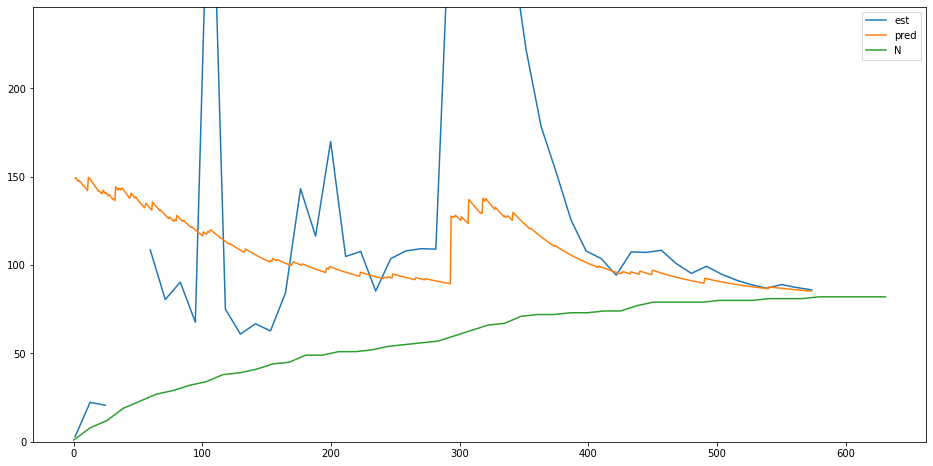

In [38]:
MLE_preds, MLE_LLs, MLE_params = plot_predictions(compute_MLE, (p,beta), cascade, alpha, mu)

> **Question:**  
> Plot on three different subplots (using ``plt.subplots``)
> - the MLE loglikelihoods along with the true loglikelihoods as functions of time (i.e end of the observation window)
> - same for the MLE parameter $p$ along with the true one
> - same for the MLE parameter $\beta$ along with the true one  
> Check the estimates converge to their true values for large observation windows

In [39]:
def plot_estimates(est_LLs, est_params, cascade):
    T = est_LLs[:,0]

    # First we need to compute loglikelihoods for the true parameters
    LLs = np.empty_like(T)
    n_samples = np.empty_like(T)
    tis = cascade[:,0]

    for i,t in enumerate(tqdm(T)):
        partial_cascade = cascade[tis < t]
        LLs[i] = loglikelihood((p, beta), partial_cascade, t) 
        n_samples[i] = len(partial_cascade)


    # Then we can draw the subplots
    _, axis = plt.subplots(3)
    
    axis[0].plot(T/60, est_LLs[:,1] / n_samples, label='$log\mathcal{L}_{est}/sample$')
    axis[0].plot(T/60, LLs / n_samples, label='$log\mathcal{L}_{true}/sample$')
    axis[0].legend() 

    axis[1].plot(T/60, est_params[:,1], label='$p_{est}$')
    axis[1].plot(T/60, p * np.ones_like(T), label='$p_{true}$')
    axis[1].legend() 

    axis[2].plot(T/60, est_params[:,2], label='$beta_{est}$')
    axis[2].plot(T/60, beta * np.ones_like(T), label='$beta_{true}$')
    axis[2].set_ylim((0,0.002))
    axis[2].legend() 

100%|██████████| 50/50 [00:00<00:00, 4168.87it/s]


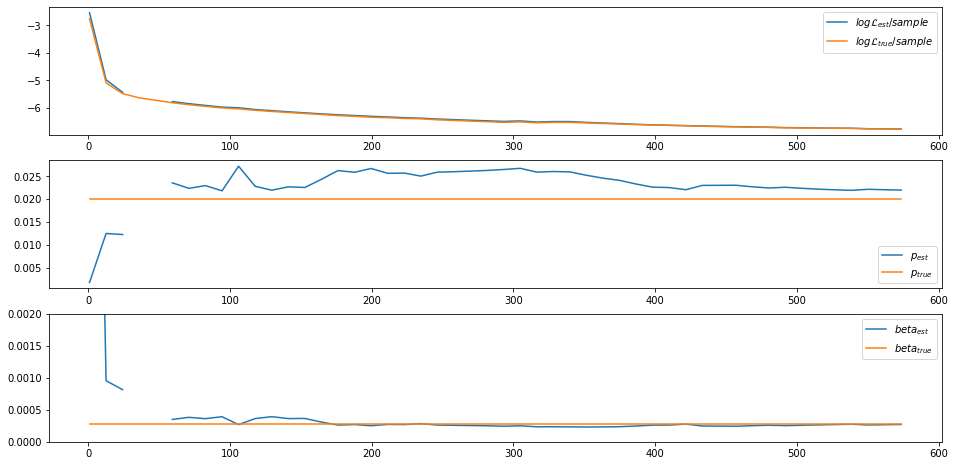

In [40]:
plot_estimates(MLE_LLs, MLE_params, cascade)

# Map estimator

We can try to use the Maximum A Posteriori estimator (MAP) instead of MLE.
MAP is the mode of the A Posteriori distribution, assuming some prior. It is a regularized version of MLE.

## Choosing a prior

We should choose our prior to reflect our knowledge about the initial distribution of parameters $(p,\beta)$.
However in our case, we have no idea about what could be a good prior for tweet cascades. We will therefore use an approach that is sometimes called **empirical Bayes** consisting in estimating the prior from the data.

The idea is first to collect a collection of good and typical set of parameters $(p_i,\beta_i)$ from some set of observed cascades. More precisely for each observed cascade:
* We evaluate its parameters by using the MLE estimator applied on the whole cascade. 
* We then use these parameters to predict the final size of the cascade for some observation window. 
* If the final size is too faraway from the true size, we reject this cascade (this is to prevent to include odd cascades that are too hard to predict).
* Otherwise we add the parameters to the collection. 

In a second stage, once we have extracted the set $(p_i,\beta_i)$,
* We observe the empirical distribution of the set $(p_i,\beta_i)$,
* We choose a parametric distribution for our prior that matches the shape of the empirical distribution.
* Finally we estimate the parameters of our prior that better matches the empirical distribution.

Here we will skip some steps and we will decide somewhat arbitrarily the type of prior distribution:
Since $p$ and $\beta$ are positive, one simple but still realistic choice of prior is to assume $(p,\beta)$ follows a *log-normal distribution*.
Put it another way, it amounts to assume $\log \theta = (\log(p), \log(\beta))$ follows a multivariate normal distribution (MVN) of parameter $(\mu, \Sigma)$ where $\mu$ is the expected vector and $\Sigma$ the covariance matrix of $\log \theta$.

> **Question:**  
> Write the expression of the aposteriori log density as a function of the loglikelihood (we won't develop the expression) and prior parameters $\mu$ and $\Sigma$. What interpretation can we give to the term linked to the prior.


Since the aposteriori density is the product of the apriori density and the likelihood,
$$
\begin{align}
\log f(\theta | \mathcal{H}_t, \mu, \Sigma) & = \log f(\theta | \mu, \Sigma) + \log\mathcal{L}_t\left(\theta\right) \text{ with } \theta = [ p,\beta ]^T \\
& = cst + -\frac{1}{2} \, (\log \theta)^T \, \Sigma^{-1} \, (\log \theta) + \log\mathcal{L}_t\left(\theta\right) \end{align}
$$

The prior term $(\log \theta)^T \, \Sigma^{-1} \, (\log \theta)$ behaves like a classical $L2$ penalization term on $\log \theta$.

## Method of moments

We thus need to estimate the prior parameters $(\mu, \Sigma)$ from  a set of pairs $(p_i,\beta_i)$.
The simplest solution here would be to transform these pairs into $(\log(p_i),\log(\beta_i))$ and estimate from this new collection the sample mean $\mu$ and covariance $\Sigma$. This is possible because MVN is parameterized by its first two moments.

However in the general case this wouldn't work and we would need to derive an estimator for our prior parameters. In simple cases like this one, one will typically use a simple method called **method of moments**.
It consists in identifying the empirical moments observed in the data with the theoretical moments given by the parametric distribution we choosed, and isolate the parameters from these set of equations.

While not necessary here, we apply the method of moments as an exercise.
Given variables $(X_1, \dots, X_m)$ following a MVN of parameters $(\mu, \Sigma)$, $\forall i, Y_i = \exp(X_i)$,
we know that
- $\mathbb{E}(Y_i) = \exp\left(\mu_i +\frac{1}{2} \Sigma_{ii}\right)$
- $cov(Y_i,Y_j) = \exp\left(\mu_i + \mu_j +\frac{1}{2} (\Sigma_{ii} + \Sigma_{jj})\right) \, \left(\exp(\Sigma_{ij})-1\right)$

Suppose we measure from some data
> **Question:**  
> Find the expression of $\mu$ and $\Sigma$ from the sample averages $\bar{p}$, $\bar{\beta}$, variances $q_p$, $q_{\beta}$ and covariance $q_{p,\beta}$.

Applying the formulas to our problem, we get:

$$
\begin{align}
\bar{p} & = \exp\left(\mu_1 +\frac{1}{2} \Sigma_{11}\right)\\
\bar{\beta} & = \exp\left(\mu_2 +\frac{1}{2} \Sigma_{22}\right)\\
q_{p} & = \exp\left(2 \, \mu_1 + \Sigma_{11}\right) \, \left(\exp(\Sigma_{11})-1\right) = \bar{p}^2 \, \left(\exp(\Sigma_{11})-1\right) \\
q_{\beta} & = \exp\left(2 \, \mu_2 + \Sigma_{22}\right) \, \left(\exp(\Sigma_{22})-1\right) = \bar{\beta}^2 \, \left(\exp(\Sigma_{22})-1\right) \\
q_{p,\beta} & = \exp\left(\mu_1 + \mu_2 +\frac{1}{2} (\Sigma_{11} + \Sigma_{22})\right) \, \left(\exp(\Sigma_{12})-1\right) = \bar{p} \, \bar{\beta} \, \left(\exp(\Sigma_{12})-1\right)
\end{align}
$$




Thus
$$
\Sigma = \log\left( 
\begin{bmatrix}
\frac{q_{p}}{\bar{p}^2} + 1 & \quad \frac{q_{p, \beta}}{\bar{p}\, \bar{\beta}} + 1 \\
\frac{q_{p, \beta}}{\bar{p}\, \bar{\beta}} + 1 & \quad \frac{q_{\beta}}{\bar{\beta}^2} + 1
\end{bmatrix}
\right)
\quad
\mu = \log\left(
\begin{bmatrix}
\frac{\bar{p}^2}{\sqrt{q_{p} + \bar{p}^2}} \\
\frac{\bar{\beta}^2}{\sqrt{q_{\beta} + \bar{\beta}^2}}
\end{bmatrix}
\right)
$$

Note that the covariance matrix $Q$ can be rewritten as a function of more convenient measures:
$$
Q = 
\begin{bmatrix}
q_p & q_{p,\beta} \\
q_{p,\beta} & q_{\beta}
\end{bmatrix}
=
\begin{bmatrix}
\sigma_p^2 & \quad \rho_{p,\beta} \, \sigma_p \, \sigma_{\beta} \\
\rho_{p,\beta} \, \sigma_p \, \sigma_{\beta} & \sigma_{\beta}^2
\end{bmatrix}
$$
where $\sigma_p$ and $\sigma_{\beta}$ are resp. the standard deviations of $p$ and $\beta$, and where $\rho_{p,\beta}$ is the correlation coefficient between $p$ and $\beta$.

## MAP implementation

Therefore the prior can be fully specified by the list of parameters $\bar{p}$, $\bar{\beta}$, $\sigma_p$, $\sigma_{\beta}$, and $\rho_{p,\beta}$.
 
> **Question:**  
> Clone function ``compute_MLE`` into function ``compute_MAP`` below and adapt it to take into account a prior.
> The parameters of the prior will be defined as arguments of the function. Since the prior mean vector is the most probable value for ou parameters a priori, this will be used as the initial value for parameters passed to the optimization algorithm.

In [57]:
def compute_MAP(history, t, alpha, mu,
                prior_params = [ 0.02, 0.0002, 0.01, 0.001, -0.1],
                max_n_star = 1, display=False):
    """
    Returns the pair of the estimated logdensity of a posteriori and parameters (as a numpy array)

    history      -- (n,2) numpy array containing marked time points (t_i,m_i)  
    t            -- current time (i.e end of observation window)
    alpha        -- power parameter of the power-law mark distribution
    mu           -- min value parameter of the power-law mark distribution
    prior_params -- list (mu_p, mu_beta, sig_p, sig_beta, corr) of hyper parameters of the prior
                 -- where:
                 --   mu_p:     is the prior mean value of p
                 --   mu_beta:  is the prior mean value of beta
                 --   sig_p:    is the prior standard deviation of p
                 --   sig_beta: is the prior standard deviation of beta
                 --   corr:     is the correlation coefficient between p and beta
    max_n_star   -- maximum authorized value of the branching factor (defines the upper bound of p)
    display      -- verbose flag to display optimization iterations (see 'disp' options of optim.optimize)
    """
    
    # Compute prior moments
    mu_p, mu_beta, sig_p, sig_beta, corr = prior_params
    sample_mean = np.array([mu_p, mu_beta])
    cov_p_beta = corr * sig_p * sig_beta
    Q = np.array([[sig_p ** 2, cov_p_beta], [cov_p_beta, sig_beta **2]])
    
    # Apply method of moments
    cov_prior = np.log(Q / sample_mean.reshape((-1,1)) / sample_mean.reshape((1,-1)) + 1)
    mean_prior = np.log(sample_mean) - np.diag(cov_prior) / 2.

    # Compute the covariance inverse (precision matrix) once for all
    inv_cov_prior = np.asmatrix(cov_prior).I

    # Define the target function to minimize as minus the log of the a posteriori density    
    def target(params):
        log_params = np.log(params)
        
        if np.any(np.isnan(log_params)):
            return np.inf
        else:
            dparams = np.asmatrix(log_params - mean_prior)
            prior_term = float(- 1/2 * dparams * inv_cov_prior * dparams.T)
            logLL = loglikelihood(params, history, t)
            return - (prior_term + logLL)
      
    EM = mu * (alpha - 1) / (alpha - 2)
    eps = 1.E-8

    # Set realistic bounds on p and beta
    p_min, p_max       = eps, max_n_star/EM - eps
    beta_min, beta_max = 1/(3600. * 24 * 10), 1/(60. * 1)
    
    # Define the bounds on p (first column) and beta (second column)
    bounds = optim.Bounds(
        np.array([p_min, beta_min]),
        np.array([p_max, beta_max])
    )
    
    # Run the optimization
    res = optim.minimize(
        target, sample_mean,
        method='Powell',
        bounds=bounds,
        options={'xtol': 1e-8, 'disp': display}
    )
    # Returns the loglikelihood and found parameters
    return(-res.fun, res.x)

Since we haven't used real data so far, let's test our method on the faked following values
$$
\begin{bmatrix}
\bar{p}\\
\bar{\beta}
\end{bmatrix}
=
\begin{bmatrix}
0.02\\
0.0002
\end{bmatrix}
\quad
Q = 
\begin{bmatrix}
q_p & q_{p,\beta} \\
q_{p,\beta} & q_{\beta}
\end{bmatrix}
=
\begin{bmatrix}
\sigma_p^2 & \quad \rho_{p,\beta} \, \sigma_p \, \sigma_{\beta} \\
\rho_{p,\beta} \, \sigma_p \, \sigma_{\beta} & \sigma_{\beta}^2
\end{bmatrix}
$$
with standard deviations $\sigma_p = 0.01$ and $\sigma_{\beta} = 0.001$ and a correlation coefficient of $\rho_{p,\beta} = -0.1$.
 
 > **Question:**  
 > Evaluate the MAP estimator as you did for MLE.
 > What do you observe when you compare both results, especially for early times?

  0%|          | 0/50 [00:00<?, ?it/s]/usr/lib/python3/dist-packages/scipy/optimize/_minimize.py:515: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
<ipython-input-41-14157fb8cf56>:37: RuntimeWarning: invalid value encountered in log
  log_params = np.log(params)
/usr/lib/python3/dist-packages/scipy/optimize/optimize.py:1975: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
100%|██████████| 50/50 [00:01<00:00, 31.72it/s]


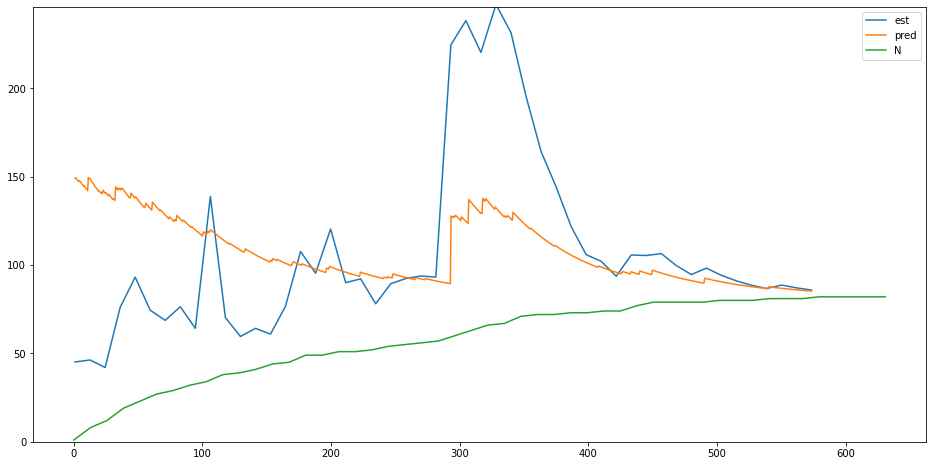

In [42]:
prior_params = [ 0.02, 0.0002, 0.01, 0.001, -0.1]
def compute_MAP_with_prior(history, t, alpha, mu):
    return compute_MAP(history, t, alpha, mu, prior_params=prior_params)

MAP_preds, MAP_LLs, MAP_params = plot_predictions(compute_MAP_with_prior, (p,beta), cascade, alpha, mu)
                                                  

100%|██████████| 50/50 [00:00<00:00, 3497.00it/s]


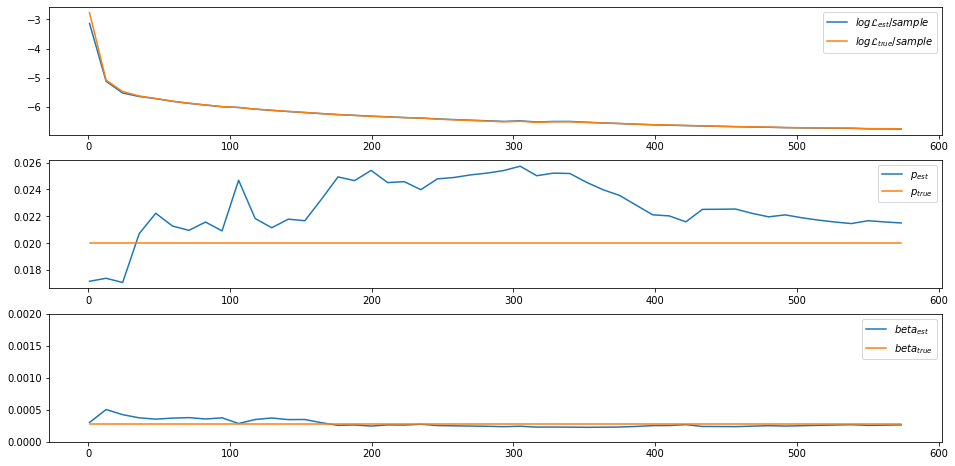

In [43]:
plot_estimates(MAP_LLs, MAP_params, cascade)

In order to ease comparisons, we need to draw several estimations on the same plot.

> **Question:**  
> Implement function ``compare_estimator_predictions`` and run it several times on different cascades sampled from the same set of parameters.

In [44]:
def compare_estimator_predictions(estimators, params, cascade, alpha, mu):
    """
    Draw on the same plot the estimation from several estimators along with the true prediction
    
    estimators -- a dictionary whose
               --  * keys are estimator names
               --  * mapped values are the estimator functions with the same signature as compute_MLE
    params     -- the true parameter tuple (p,beta) of the Hawkes process (to draw the estimation)
    alpha     -- power parameter of the power-law mark distribution
    mu        -- min value parameter of the power-law mark distribution
    T         -- 1D-array of times (i.e ends of observation window)
    n_tries   -- number of times the estimator is run. Best result is kept.
    """
    
    # Compute the predictions according to the true parameters
    preds = predictions((p,beta), cascade, alpha, mu)
    
    # Compute the counting process
    N = counting_process(cascade)

    for name,estimator in estimators.items():
        # Compute the predictions according to the estimator
        est_preds, est_LLs, est_params = predictions_from_estimator(estimator, cascade, alpha, mu)
        plt.plot(est_preds[:,0]/60, est_preds[:,1], label=name)
        
    plt.plot(preds[:,0]/60, preds[:,1], label='pred')
    plt.plot(N[:,0]/60, N[:,1], label='N')
    plt.ylim([0,N[-1,1]*3])
    plt.legend()


/usr/lib/python3/dist-packages/scipy/optimize/_minimize.py:515: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
/usr/lib/python3/dist-packages/scipy/optimize/optimize.py:1975: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
 32%|███▏      | 16/50 [00:00<00:00, 73.52it/s]

         n = 55
        LL = -6.4403 MLE = -6.4223
         p = 0.02200 MLE = 0.02725
      beta = 0.00028 MLE = 0.00023
    n_star = 0.77000 MLE = 0.95369
rel. error = 0.09


  0%|          | 0/50 [00:00<?, ?it/s]/usr/lib/python3/dist-packages/scipy/optimize/_minimize.py:515: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
<ipython-input-41-14157fb8cf56>:37: RuntimeWarning: invalid value encountered in log
  log_params = np.log(params)
/usr/lib/python3/dist-packages/scipy/optimize/optimize.py:1975: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
100%|██████████| 50/50 [00:01<00:00, 37.41it/s]


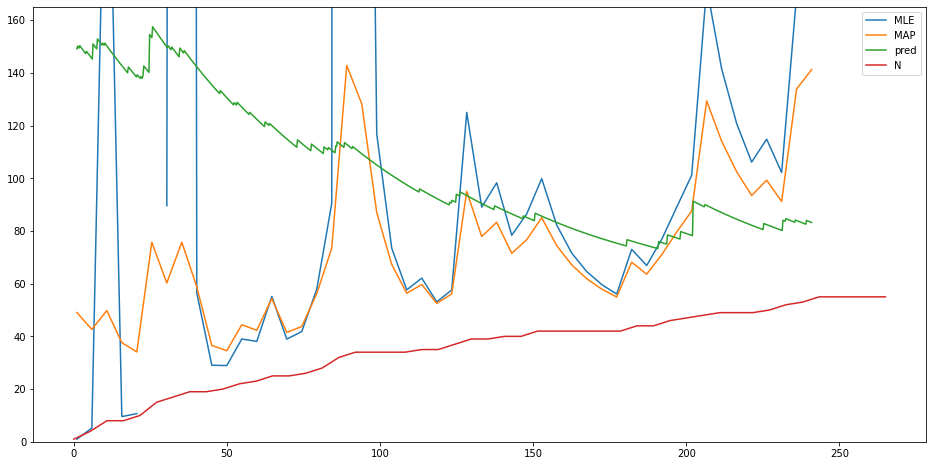

In [45]:
p, beta = 0.022, 1/3600.
alpha, mu = 2.4, 10
m0 = 1000

estimators = { "MLE": compute_MLE, "MAP": compute_MAP_with_prior}

# Generate a new cascade
cascade = get_new_cascade(m0, p, beta, alpha, mu)

# Compute and plot the estimations
compare_estimator_predictions(estimators, (p,beta), cascade, alpha, mu)


# Evaluation

We want now to compare performances of MLE and MAP on a large number of cascades.
Before processing real tweets, we first test estimators on simulated data.

## Data generation

These cascades will be drawn from Hawkes processes whose parameters are themselves drawn from our prior distribution on $(p,\beta)$.

The first step is to sample parameters of many Hawkes processes. Because *numpy* only allows to sample univariate log normal distribution (see ``np.random.lognormal``), one needs to implement our own function.

> **Question:**  
> Implement function ``multivariate_log_normal`` based on ``np.random.multivariate_normal`` (we will restrict our function for random vector of size 2). 
> Test the function by drawing histograms of $p$ and $\beta$ along with their theoretical densities (you can use function ``plot_log_normal_density`` for this purpose).

In [46]:
def multivariate_log_normal(mu, cov, size=1):
    """
    Returns a (size,2)-array containing iid samples of (p,beta) drawn from a given prior distribution

    mu   -- mean vector of size 2
    cov  -- covariance matrix of size 2
    size -- number of samples
    """
    
    mu, cov = np.asarray(mu), np.asarray(cov)
    cov_on_log  = np.log(cov / mu.reshape((-1,1)) / mu.reshape((1,-1)) + 1)
    mean_on_log = np.log(mu) - np.diag(cov_on_log) / 2.

    log_params = np.random.multivariate_normal(mean_on_log, cov_on_log, size=size)
    return np.exp(log_params)

In [47]:
def plot_log_normal_density(X, mu, var, color='r'):
    """
    Plots the density of a lognormal distribution

    X    -- 1D-array of values whose density has to be computed
    mu   -- mean
    var  -- variance
    """
    
    log_var = np.log(var / (mu ** 2) + 1)
    log_mu = np.log(mu) - log_var / 2.     
    plt.plot(X, np.exp(- (np.log(X) - log_mu)**2 / (2. * log_var)) / (X * np.sqrt(2 * np.pi * log_var)), color)


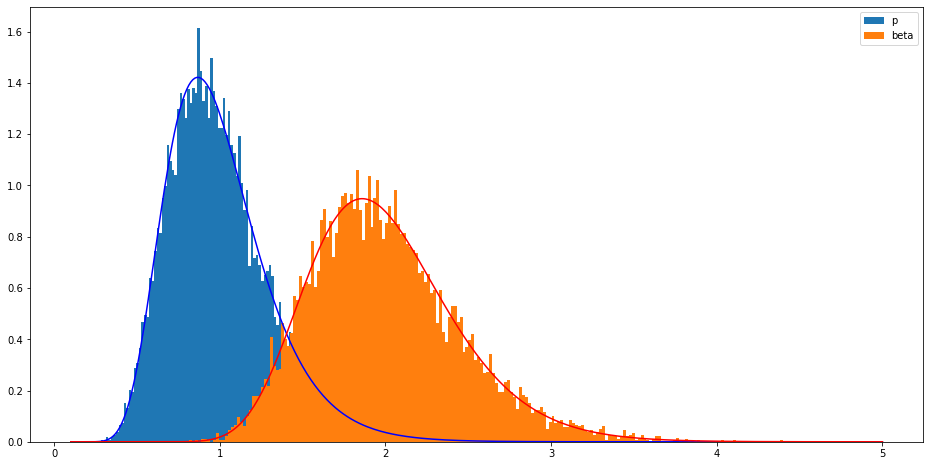

In [48]:
mu0, cov0 = np.array([1,2]), np.array([[0.1,0.01],[0.01, 0.2]])

params = multivariate_log_normal(mu0, cov0, size=10000)
_ = plt.hist(params[:,0], bins=200, density=True, log=False, label='p')
_ = plt.hist(params[:,1], bins=200, density=True, log=False, label='beta')
plt.legend()

# Compare with theoretical density
X = np.linspace(0.1, 5, 400)
plot_log_normal_density(X, mu0[0], cov0[0,0], 'b')
plot_log_normal_density(X, mu0[1], cov0[1,1], 'r')


Since eventually we want to test our estimators on real datas that are saved into csv files, the next step is to save and load cascades from / to files. To this end we provide beneath two functions that you might want to test.

In [49]:
default_cascade_directory = './cache/cascades'

def write_cascade(cascade, casc_index, cascade_directory=default_cascade_directory):
    """
    Save a cascade into a csv file

    cascade           -- (n,2) numpy array containing marked time points (t_i,m_i)
    casc_index        -- index of the cascade (int)
    cascade_directory -- directory where the file is saved
    """
    
    if not os.path.exists(cascade_directory):
        os.makedirs(cascade_directory, exist_ok=False)
    df = pd.DataFrame(cascade, columns=['time', 'magnitude'])
    df.to_csv(os.path.join(cascade_directory, 'casc-{}.csv'.format(casc_index)), columns=['time', 'magnitude'])

def read_cascade(casc_index, cascade_directory=default_cascade_directory):
    """
    Reads a cascade csv file and returns its cascade as a numpy array containing marked time points (t_i,m_i)

    casc_index        -- index of the cascade (int)
    cascade_directory -- directory where the file is saved
    """
    
    df = pd.read_csv(os.path.join(cascade_directory, 'casc-{}.csv'.format(casc_index)), names=['time', 'magnitude'], header=0)
    return df.to_numpy()

In [50]:
# Write and read a cascade at index 0
write_cascade(cascade, 0)
saved_cascade = read_cascade(0)

# Check there is no difference
max_diff = np.max(np.abs(saved_cascade - cascade))
print(f"Maximal difference between original and saved cascades = {max_diff}")

Maximal difference between original and saved cascades = 1.8189894035458565e-12


Now we need to generate many cascades. 

> **Question:**  
> Implement function ``generate_pseudo_data`` that generates from some prior a set of cascades and saves them on disks. And don't forget to test.


In [51]:
def generate_pseudo_data(n, prior_params, m0, alpha, mu):
    """
    Sample cascades from some parameter prior and save them on disk.
    
    n            -- number of cascades to generate
    prior_params -- list (mu_p, mu_beta, sig_p, sig_beta, corr) of hyper parameters of the prior
    m0           -- magnitude of the initial tweet at t = 0.
    alpha        -- power parameter of the power-law mark distribution
    mu           -- min value parameter of the power-law mark distribution
    """
    
    # Generate parameters from prior
    mu_p, mu_beta, sig_p, sig_beta, corr = prior_params
    mu_params = [mu_p, mu_beta]
    cov_p_beta = corr * sig_p * sig_beta
    Q = np.array([[sig_p ** 2, cov_p_beta], [cov_p_beta, sig_beta **2]])
    params = multivariate_log_normal(mu_params, Q, size=n)

    # Then generate cascades
    for i,(p,beta) in enumerate(params):
        cascade = simulate_marked_exp_hawkes_process((p,beta), m0, alpha, mu)
        write_cascade(cascade, i)

In [52]:
alpha, mu = 2.4, 10
m0 = 1000
generate_pseudo_data(100, prior_params, m0, alpha, mu)

It's now time to test estimators. To evaluate the quality of prediction, we use the ean absolute error (MAE):
$$ MAE(y,\hat{y}) = |y - \hat{y}|$$

> **Question:**  
> Complete function ``evaluate_ARE`` and test by plotting predictions for different time windows.


In [53]:
def evaluate_ARE(ids, alpha, mu, estimators, T):
    """
    Compute the mean absolute error (MAE) of different estimators on a subset of your dataset.
    Returns a 3D-array of shape (length of T, number of estimators, length of ids)
    
    ids        -- a list of sample indexes (e.g range(40) processes the 40 first samples)
    alpha      -- power parameter of the power-law mark distribution
    mu         -- min value parameter of the power-law mark distribution
    estimators -- a dictionary whose
               --  * keys are estimator names
               --  * mapped values are the estimator functions with the same signature as compute_MLE
    T          -- 1D-array of times (i.e ends of observation window)
    """

    ARE = np.empty((len(T), len(estimators), len(ids)))
    for i,id in enumerate(tqdm(ids)):
        cascade = read_cascade(id)
        N = len(cascade)
        for j,(name,estimator) in enumerate(estimators.items()):
            N_est, LLs, params = predictions_from_estimator(estimator, cascade, alpha, mu, T, n_tries=1, slider=False)
            ARE[:,j,i] = np.abs(N - N_est[:,1]) 

    return ARE

In [54]:
T = 60 * np.array([ 15, 30, 60, 120, 240])
ARE = evaluate_ARE(range(40), alpha, mu, estimators, T)

  0%|          | 0/40 [00:00<?, ?it/s]/usr/lib/python3/dist-packages/scipy/optimize/_minimize.py:515: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
/usr/lib/python3/dist-packages/scipy/optimize/optimize.py:1975: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
<ipython-input-41-14157fb8cf56>:37: RuntimeWarning: invalid value encountered in log
  log_params = np.log(params)
100%|██████████| 40/40 [00:06<00:00,  6.55it/s]


In [55]:
def plot_ARE(estimators, ARE):
    n_Tobs, n_est, n_samples = ARE.shape
    n_estimators = len(estimators)
        # Then we can draw the subplots
    _, axis = plt.subplots(n_Tobs)
    
    for i, ax in enumerate(axis):
        for j,(name,estimator) in enumerate(estimators.items()):
            ax.semilogy(ARE[i,j], label=name)
        ax.legend()


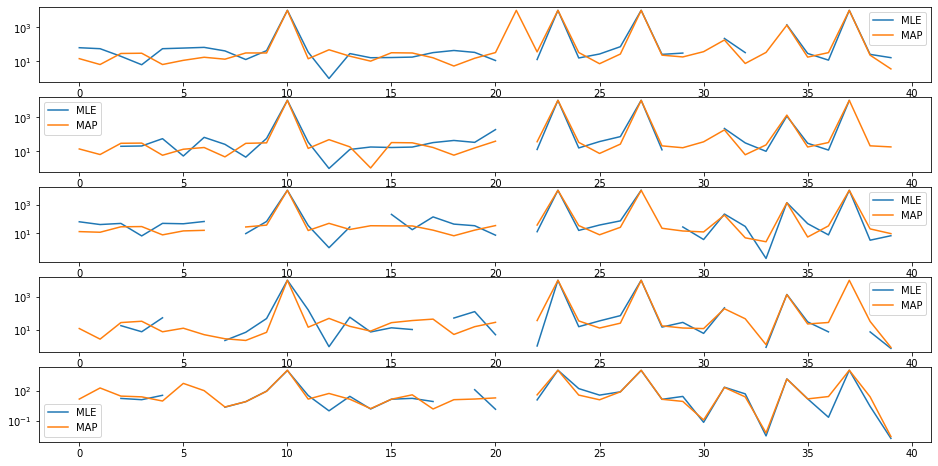

In [56]:
plot_ARE(estimators, ARE)